In [ ]:
!pip install gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [4]:
import pandas as pd
import numpy as np
import math
import torch
# import gpytorch
from matplotlib import pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = pd.read_csv(r'/content/drive/MyDrive/STAT0035/Cleaned_data.csv', index_col = 0)

In [7]:
data_sub = data[['Date.time',
 'Power.me',
 'Pot.Power.me',
 'Wind.speed.me',
 'Power.factor.cosphi.me',
 'Front.bearing.temp.me',
 'Rear.bearing.temp.me',
 'Stator1.temp.me',
 'Nacelle.ambient.temp.me',
 'Nacelle.temp.me',
 'Transformer.temp.me',
 'Gear.oil.temp.me',
 'Generator.bearing.rear.temp.me',
 'Generator.bearing.front.temp.me',
 'Gear.oil.temp.me.1',
 'Top.box.temp.me',
 'Hub.temp.me',
 'Conv.Amb.temp.me',
 'Rotor.bearing.temp.me',
 'Transformer.cell.temp.me',
 'Motor.axis1.temp.me',
 'Motor.axis2.temp.me',
 'Motor.axis3.temp.me',
 'CPU.temp.me',
 'Rotor.speed.me',
 'Blade.ang.pitch.pos.A.me',
 'Blade.ang.pitch.pos.B.me',
 'Blade.ang.pitch.pos.C.me',
 'Gear.oil.inlet.press.me',
 'Gear.oil.pump.press.me',
 'Drive.train.acceleration.me',
 'Tower.Acceleration.x',
 'Tower.Acceleration.y',
 'turbine',
 'year']]


### Standardise all variables except date-time

In [ ]:
# Basic info
print(data_sub.info())

# Summary statistics for numerical features
print(data_sub.describe())

# Check for missing values
print(data_sub.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1018494 entries, 0 to 1169060
Data columns (total 35 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   Date.time                        1018494 non-null  object 
 1   Power.me                         1018494 non-null  float64
 2   Pot.Power.me                     1018494 non-null  float64
 3   Wind.speed.me                    1018494 non-null  float64
 4   Power.factor.cosphi.me           1018493 non-null  float64
 5   Front.bearing.temp.me            1009827 non-null  float64
 6   Rear.bearing.temp.me             1009827 non-null  float64
 7   Stator1.temp.me                  1018494 non-null  float64
 8   Nacelle.ambient.temp.me          1009827 non-null  float64
 9   Nacelle.temp.me                  1009826 non-null  float64
 10  Transformer.temp.me              1009827 non-null  float64
 11  Gear.oil.temp.me                 1009825 non-null 

<ipython-input-14-9935b5d64318>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_sub.corr(), annot=True, cmap='coolwarm')


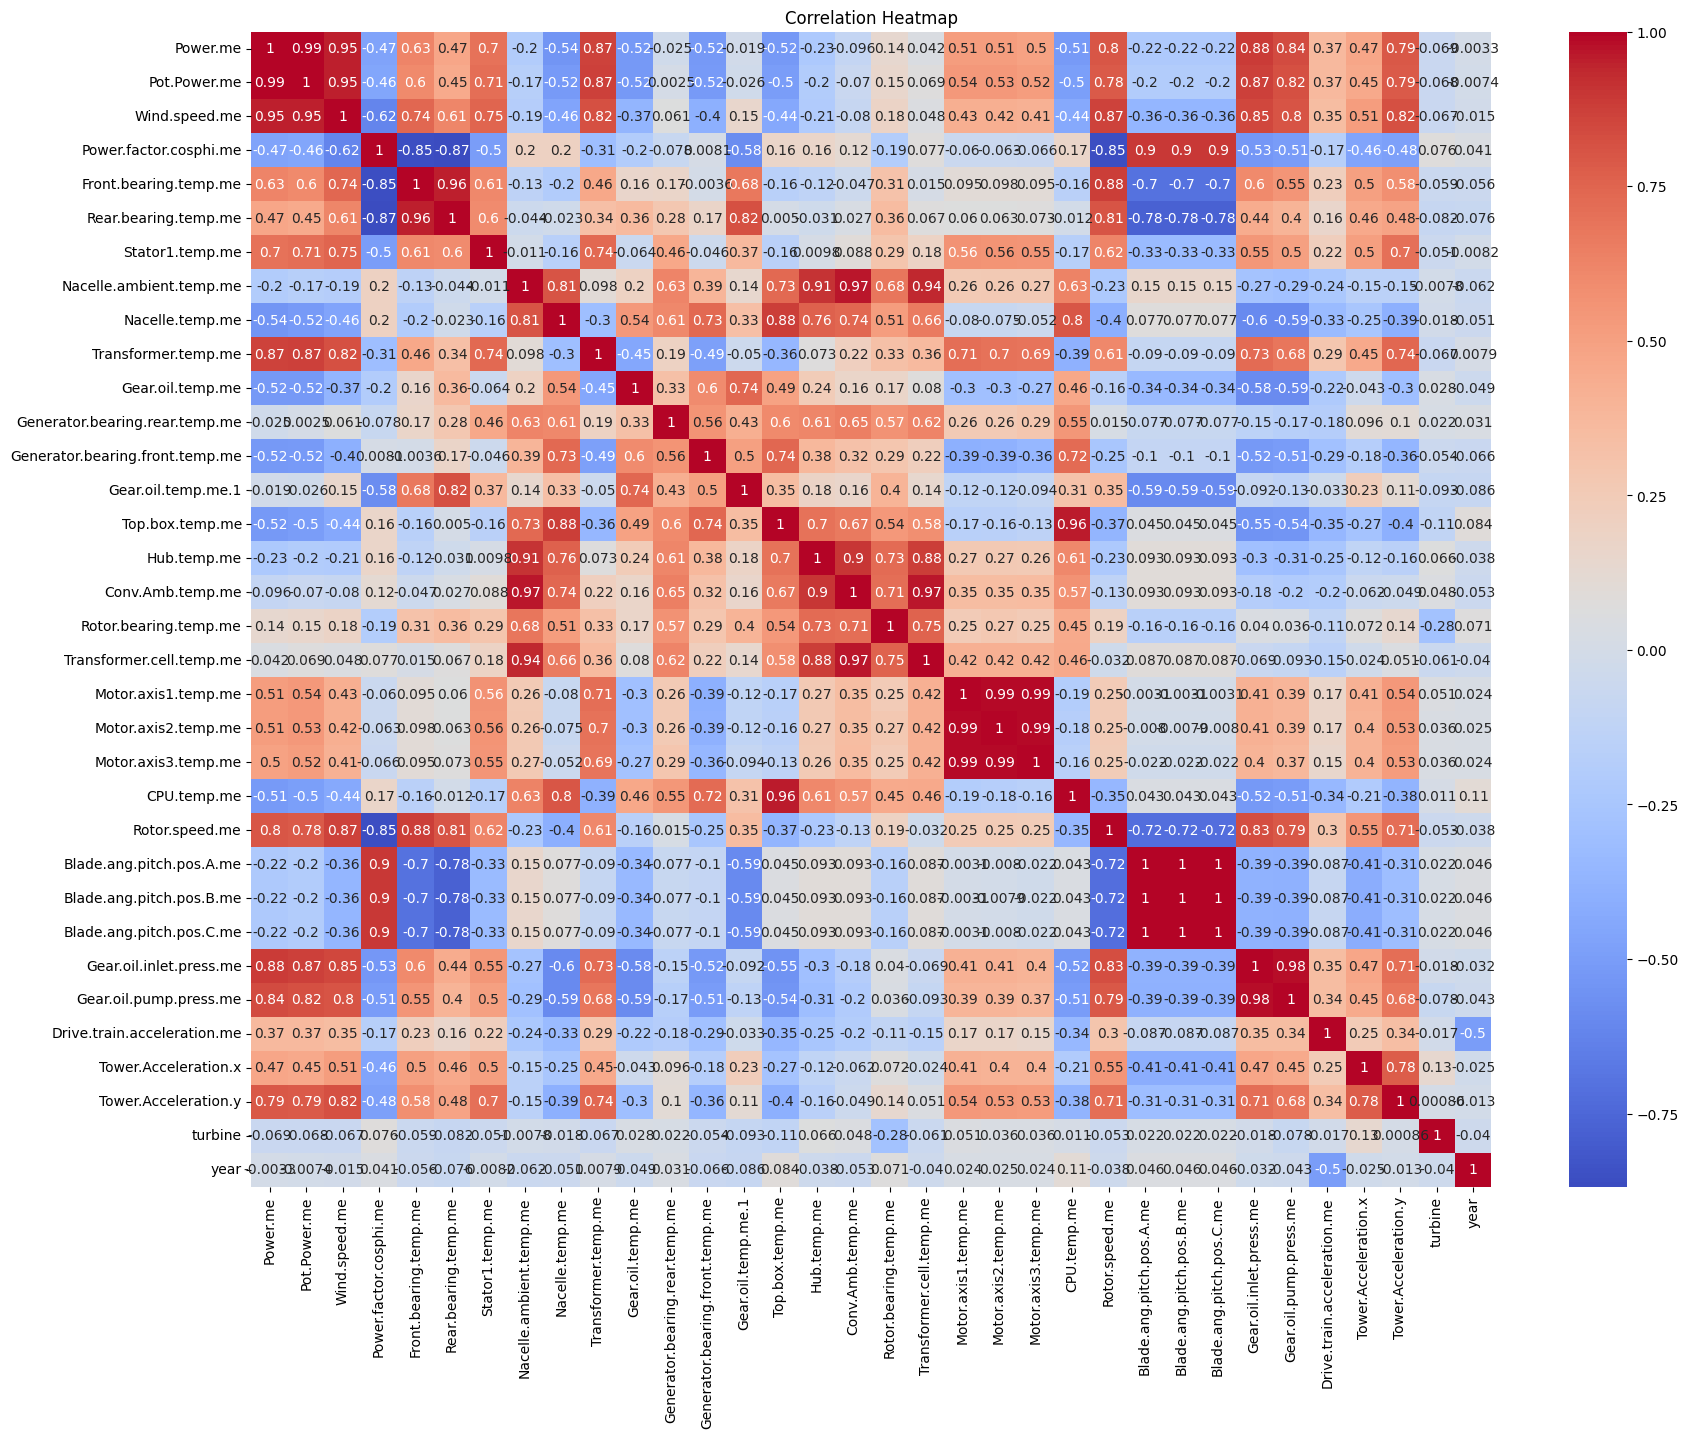

In [ ]:
plt.figure(figsize=(20, 15))
sns.heatmap(data_sub.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

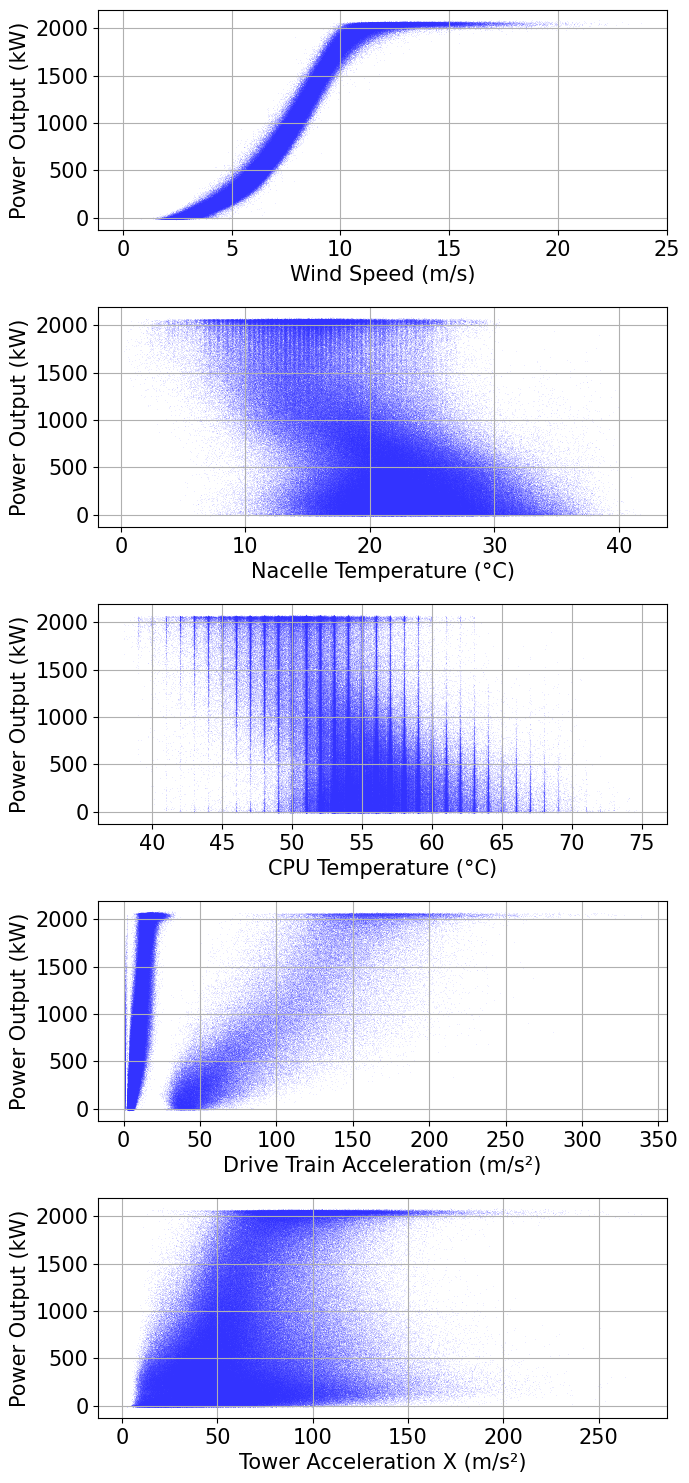

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#Variables to plot against Power.me
training_var = [
    'Wind.speed.me',
    'Nacelle.temp.me',
    'CPU.temp.me',
    'Drive.train.acceleration.me',
    'Tower.Acceleration.x',
]

# training_var = [
#  'Wind.speed.me',
#  'Power.factor.cosphi.me',
#  'Front.bearing.temp.me',
#  'Stator1.temp.me',
#  'Nacelle.ambient.temp.me',
#  'Nacelle.temp.me',
#  'Transformer.temp.me',
#  'Gear.oil.temp.me',
#  'Generator.bearing.rear.temp.me',
#  'Generator.bearing.front.temp.me',
#  'Motor.axis1.temp.me',
#  'CPU.temp.me',
#  'Rotor.speed.me',
#  'Gear.oil.inlet.press.me',
#  'Drive.train.acceleration.me',
#  'Tower.Acceleration.x',
#  'Tower.Acceleration.y',
#  ]

custom_labels = [
    'Wind Speed (m/s)',
    'Nacelle Temperature (°C)',
    'CPU Temperature (°C)',
    'Drive Train Acceleration (m/s²)',
    'Tower Acceleration X (m/s²)',
]

# Number of variables to plot
n_vars = len(training_var)

# Create a figure to hold all subplots
fig, axes = plt.subplots(n_vars, 1, figsize=(7, 3*n_vars))

# If only one variable, wrap the axes object in a list for consistent indexing
if n_vars == 1:
    axes = [axes]

# Loop through each variable and create its subplot
for i, var in enumerate(training_var):
    sns.scatterplot(data=data_sub, x=var, y='Power.me', ax=axes[i], alpha=0.1, s=0.5, color='blue')
    axes[i].set_xlabel(custom_labels[i], fontsize=15)
    axes[i].set_ylabel('Power Output (kW)', fontsize=15)
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=15)

# Here we adjust the height spacing
plt.subplots_adjust(hspace=20)  # Change the value as needed for more or less space

# Adjust the layout so the plots do not overlap
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Preparing the dataset
X = data_sub.drop(['Power.me', 'Date.time', 'turbine', 'year'], axis=1).fillna(0)  # Dropping non-numeric and target variables
y = data_sub['Power.me'].fillna(0)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Performance
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")

# Feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {X_train.columns[indices[f]]} ({importances[indices[f]]})")

RMSE: 24.01784025597748
Feature ranking:
1. feature Rotor.speed.me (0.8901230462189735)
2. feature Pot.Power.me (0.05936721338912895)
3. feature Wind.speed.me (0.04419220012923518)
4. feature Blade.ang.pitch.pos.A.me (0.0023612634815948275)
5. feature Blade.ang.pitch.pos.B.me (0.0009404054231147559)
6. feature Blade.ang.pitch.pos.C.me (0.0009171900898369501)
7. feature Power.factor.cosphi.me (0.00048225459135434065)
8. feature Conv.Amb.temp.me (0.00011985309230472512)
9. feature Nacelle.ambient.temp.me (0.00011944872761454878)
10. feature Tower.Acceleration.x (0.00010663055908183984)
11. feature Nacelle.temp.me (0.00010125435345538996)
12. feature Hub.temp.me (0.0001011524742584741)
13. feature Drive.train.acceleration.me (9.321881125971846e-05)
14. feature Motor.axis2.temp.me (8.558717932579508e-05)
15. feature Stator1.temp.me (7.354625307600296e-05)
16. feature Tower.Acceleration.y (7.070973592743304e-05)
17. feature Motor.axis1.temp.me (6.987894045706465e-05)
18. feature Front.beari

In [ ]:
# Remove negative power values
data_sub = data_sub[data_sub['Power.me'] >= 0]

# **Result for Chapter 6.2.1**

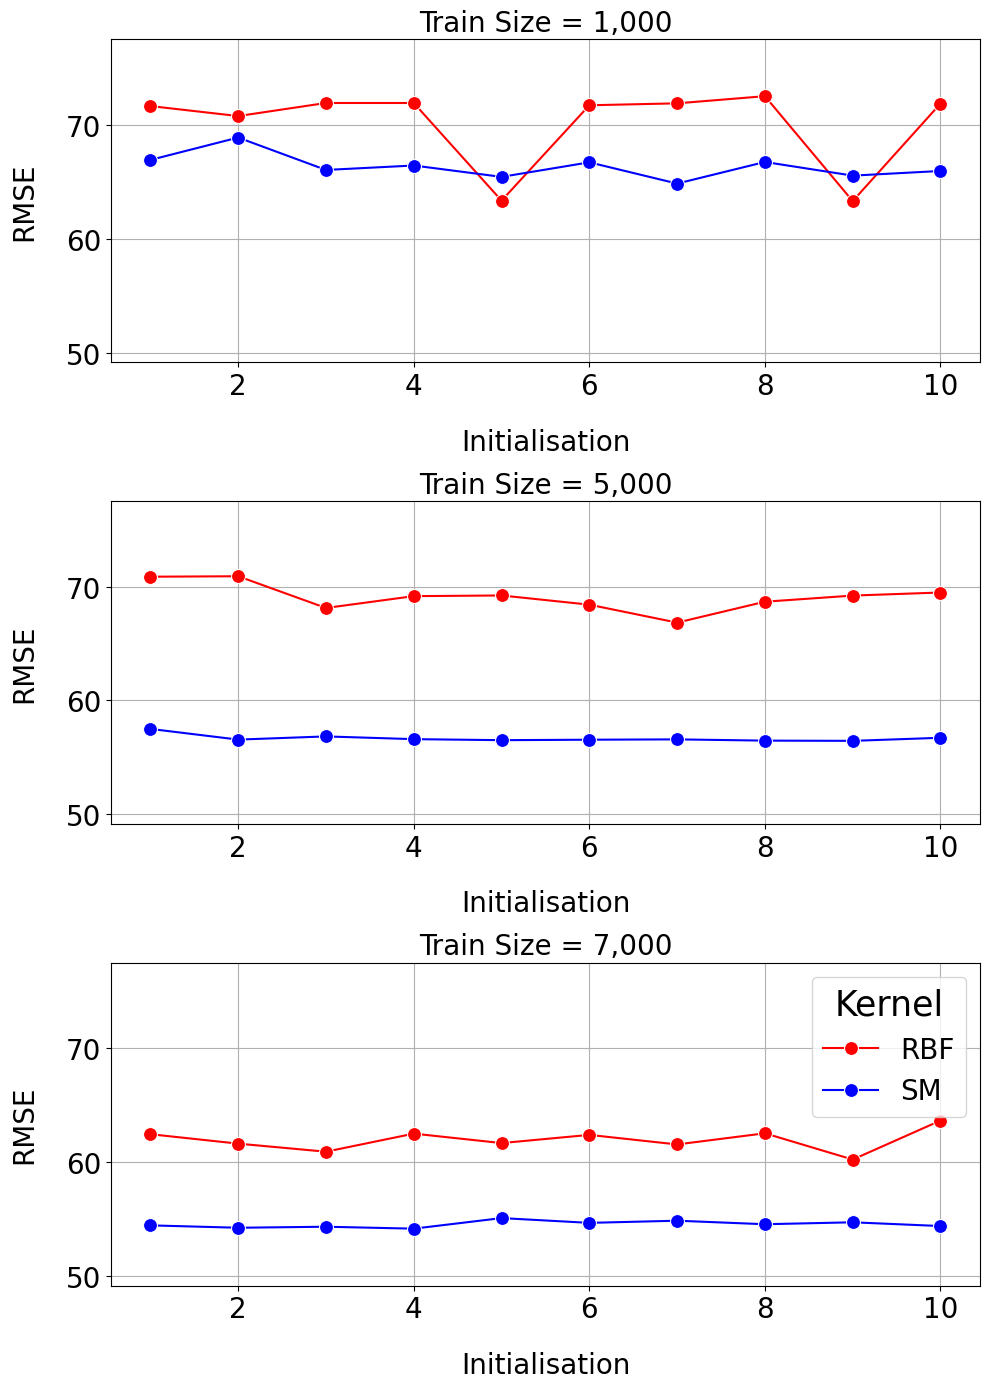

In [37]:
# Now that we have the data provided by the user, we can create a dataframe and proceed with the visualization.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Creating the data manually based on the provided text.
data = [
    # N = 1,000
    {'N': "1,000", 'Init': 1, 'RBF': 71.68, 'SM': 66.94},
    {'N': "1,000", 'Init': 2, 'RBF': 70.8, 'SM': 68.91},
    {'N': "1,000", 'Init': 3, 'RBF': 71.95, 'SM': 66.06},
    {'N': "1,000", 'Init': 4, 'RBF': 71.95, 'SM': 66.45},
    {'N': "1,000", 'Init': 5, 'RBF': 63.36, 'SM': 65.45},
    {'N': "1,000", 'Init': 6, 'RBF': 71.75, 'SM': 66.73},
    {'N': "1,000", 'Init': 7, 'RBF': 71.92, 'SM': 64.86},
    {'N': "1,000", 'Init': 8, 'RBF': 72.55, 'SM': 66.76},
    {'N': "1,000", 'Init': 9, 'RBF': 63.32, 'SM': 65.56},
    {'N': "1,000", 'Init': 10, 'RBF': 71.9, 'SM': 65.97},
    # N = 5,000
    {'N': "5,000", 'Init': 1, 'RBF': 70.89, 'SM': 57.5},
    {'N': "5,000", 'Init': 2, 'RBF': 70.93, 'SM': 56.56},
    {'N': "5,000", 'Init': 3, 'RBF': 68.14, 'SM': 56.84},
    {'N': "5,000", 'Init': 4, 'RBF': 69.18, 'SM': 56.6},
    {'N': "5,000", 'Init': 5, 'RBF': 69.24, 'SM': 56.51},
    {'N': "5,000", 'Init': 6, 'RBF': 68.43, 'SM': 56.55},
    {'N': "5,000", 'Init': 7, 'RBF': 66.85, 'SM': 56.58},
    {'N': "5,000", 'Init': 8, 'RBF': 68.69, 'SM': 56.47},
    {'N': "5,000", 'Init': 9, 'RBF': 69.23, 'SM': 56.45},
    {'N': "5,000", 'Init': 10, 'RBF': 69.5, 'SM': 56.72},
    # N = 7,000
    {'N': "7,000", 'Init': 1, 'RBF': 62.46, 'SM': 54.44},
    {'N': "7,000", 'Init': 2, 'RBF': 61.63, 'SM': 54.23},
    {'N': "7,000", 'Init': 3, 'RBF': 60.92, 'SM': 54.32},
    {'N': "7,000", 'Init': 4, 'RBF': 62.51, 'SM': 54.15},
    {'N': "7,000", 'Init': 5, 'RBF': 61.68, 'SM': 55.08},
    {'N': "7,000", 'Init': 6, 'RBF': 62.4, 'SM': 54.66},
    {'N': "7,000", 'Init': 7, 'RBF': 61.56, 'SM': 54.85},
    {'N': "7,000", 'Init': 8, 'RBF': 62.54, 'SM': 54.54},
    {'N': "7,000", 'Init': 9, 'RBF': 60.23, 'SM': 54.71},
    {'N': "7,000", 'Init': 10, 'RBF': 63.66, 'SM': 54.38},
]

# Convert the list to a DataFrame
df = pd.DataFrame(data)

# Reshape the DataFrame to 'long form' which is suitable for seaborn line plots
df_long = pd.melt(df, id_vars=['N', 'Init'], var_name='Kernel', value_name='RMSE')


# Adjusting the plot with the specified requirements: color, ticker, legend and axis names size, and appropriate y axis scales.

# Setting the color palette for the kernels
kernel_colors = {"RBF": "red", "SM": "blue"}

# We'll create a single row of subplots, where each subplot will represent one of the N values.
# The plots will be more square, and we will have a shared legend and y-axis tickers.

# Adjusting the legend placement to not overlap with the plots

# Creating the plots again with the adjusted legend
fig, axes = plt.subplots(3, 1, figsize=(10, 14), sharey=True)

for ax, n_value in zip(axes, df['N'].unique()):
    sns.lineplot(
        data=df_long[df_long['N'] == n_value],
        x='Init',
        y='RMSE',
        hue='Kernel',
        palette=kernel_colors,
        marker='o',
        ax=ax, markersize=10
    )
    ax.set_title(f'Train Size = {n_value}', fontsize=20)
    ax.set_xlabel('Initialisation', fontsize=20, labelpad=20)
    ax.set_ylabel('RMSE', fontsize=20, labelpad=20)
    ax.set_ylim(df_long['RMSE'].min() - 5, df_long['RMSE'].max() + 5)  # Slightly wider ylim for better visuals
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.grid(True)

# Adjust the figure layout
plt.tight_layout()

# Remove the legends for all but the last plot
for ax in axes[:-1]:
    ax.get_legend().remove()

# Adjust legend on the last plot
axes[-1].legend(title='Kernel', fontsize=20, title_fontsize=25)

# Show the plot
plt.show()


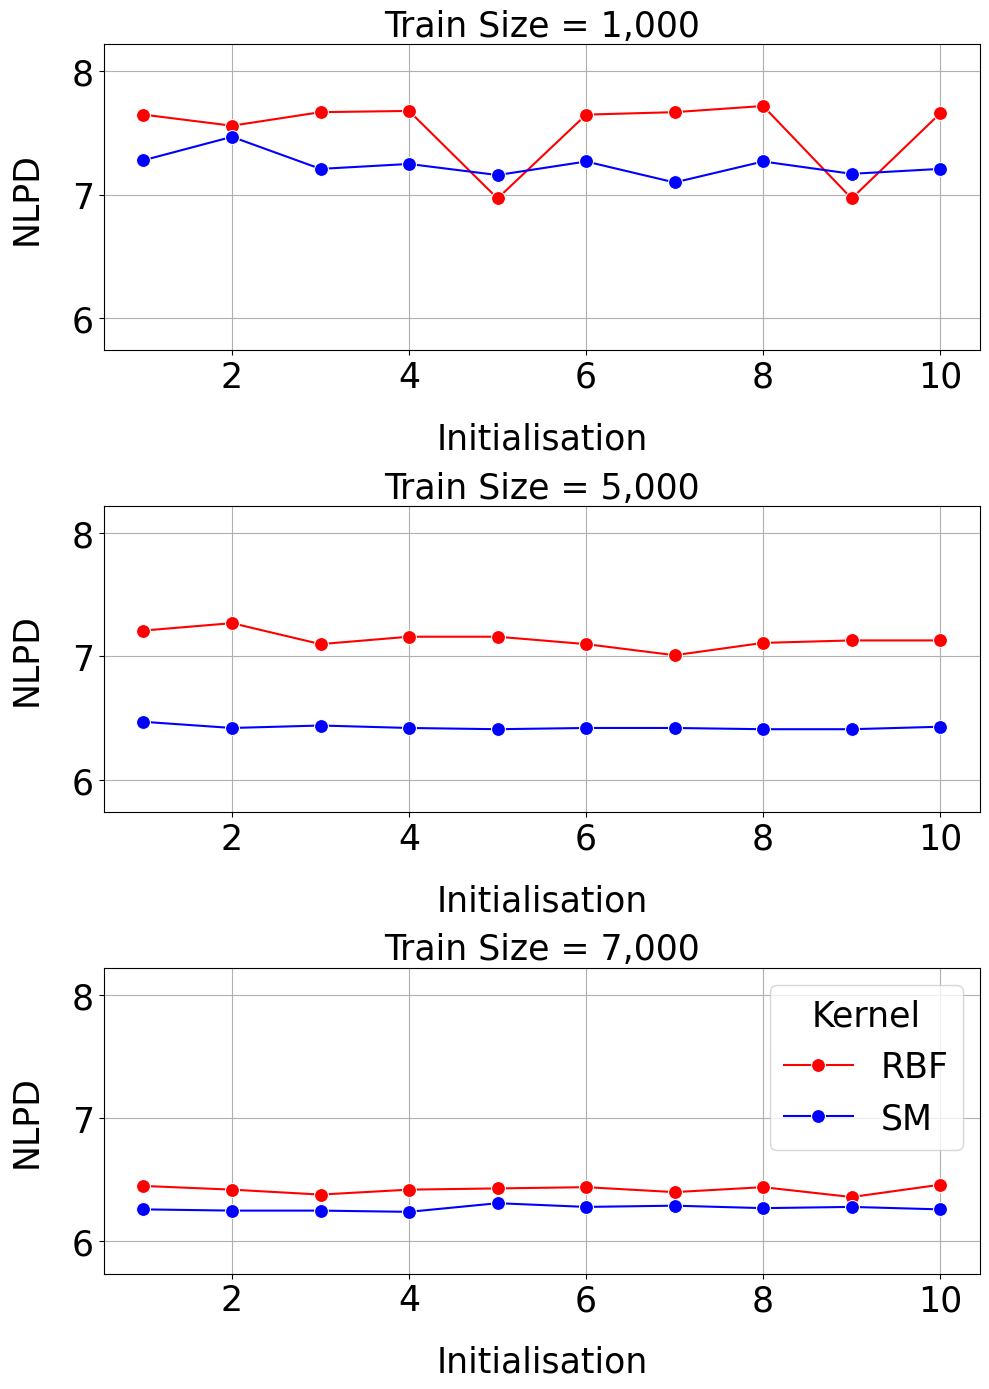

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Creating the data based on the provided text, including all NLPD values.
data = [
    # N = 1,000
    {'N': "1,000", 'Init': 1, 'RBF': 7.65, 'SM': 7.28},
    {'N': "1,000", 'Init': 2, 'RBF': 7.56, 'SM': 7.47},
    {'N': "1,000", 'Init': 3, 'RBF': 7.67, 'SM': 7.21},
    {'N': "1,000", 'Init': 4, 'RBF': 7.68, 'SM': 7.25},
    {'N': "1,000", 'Init': 5, 'RBF': 6.97, 'SM': 7.16},
    {'N': "1,000", 'Init': 6, 'RBF': 7.65, 'SM': 7.27},
    {'N': "1,000", 'Init': 7, 'RBF': 7.67, 'SM': 7.1},
    {'N': "1,000", 'Init': 8, 'RBF': 7.72, 'SM': 7.27},
    {'N': "1,000", 'Init': 9, 'RBF': 6.97, 'SM': 7.17},
    {'N': "1,000", 'Init': 10, 'RBF': 7.66, 'SM': 7.21},
    # N = 5,000
    {'N': "5,000", 'Init': 1, 'RBF': 7.21, 'SM': 6.47},
    {'N': "5,000", 'Init': 2, 'RBF': 7.27, 'SM': 6.42},
    {'N': "5,000", 'Init': 3, 'RBF': 7.1, 'SM': 6.44},
    {'N': "5,000", 'Init': 4, 'RBF': 7.16, 'SM': 6.42},
    {'N': "5,000", 'Init': 5, 'RBF': 7.16, 'SM': 6.41},
    {'N': "5,000", 'Init': 6, 'RBF': 7.1, 'SM': 6.42},
    {'N': "5,000", 'Init': 7, 'RBF': 7.01, 'SM': 6.42},
    {'N': "5,000", 'Init': 8, 'RBF': 7.11, 'SM': 6.41},
    {'N': "5,000", 'Init': 9, 'RBF': 7.13, 'SM': 6.41},
    {'N': "5,000", 'Init': 10, 'RBF': 7.13, 'SM': 6.43},
    # N = 7,000
    {'N': "7,000", 'Init': 1, 'RBF': 6.45, 'SM': 6.26},
    {'N': "7,000", 'Init': 2, 'RBF': 6.42, 'SM': 6.25},
    {'N': "7,000", 'Init': 3, 'RBF': 6.38, 'SM': 6.25},
    {'N': "7,000", 'Init': 4, 'RBF': 6.42, 'SM': 6.24},
    {'N': "7,000", 'Init': 5, 'RBF': 6.43, 'SM': 6.31},
    {'N': "7,000", 'Init': 6, 'RBF': 6.44, 'SM': 6.28},
    {'N': "7,000", 'Init': 7, 'RBF': 6.4, 'SM': 6.29},
    {'N': "7,000", 'Init': 8, 'RBF': 6.44, 'SM': 6.27},
    {'N': "7,000", 'Init': 9, 'RBF': 6.36, 'SM': 6.28},
    {'N': "7,000", 'Init': 10, 'RBF': 6.46, 'SM': 6.26},
]

# Convert the list to a DataFrame
df = pd.DataFrame(data)

# Reshape the DataFrame to 'long form' which is suitable for seaborn line plots
df_long = pd.melt(df, id_vars=['N', 'Init'], var_name='Kernel', value_name='NLPD')

# Setting the color palette for the kernels
kernel_colors = {"RBF": "red", "SM": "blue"}

# Creating the plots with NLPD values
fig, axes = plt.subplots(3, 1, figsize=(10, 14), sharey=True)

for ax, n_value in zip(axes, df['N'].unique()):
    sns.lineplot(
        data=df_long[df_long['N'] == n_value],
        x='Init',
        y='NLPD',
        hue='Kernel',
        palette=kernel_colors,
        marker='o',
        ax=ax, markersize = 10
    )
    ax.set_title(f'Train Size = {n_value}', fontsize=25)
    ax.set_xlabel('Initialisation', fontsize=25, labelpad=20)
    ax.set_ylabel('NLPD', fontsize=25, labelpad=20)
    ax.set_ylim(df_long['NLPD'].min() - 0.5, df_long['NLPD'].max() + 0.5)  # Adjust y-axis limits for better visualization
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.grid(True)

plt.tight_layout()

# Remove the legends for all but the last plot
for ax in axes[:-1]:
    ax.get_legend().remove()

# Adjust legend on the last plot
axes[-1].legend(title='Kernel', fontsize=25, title_fontsize=25)

plt.show()

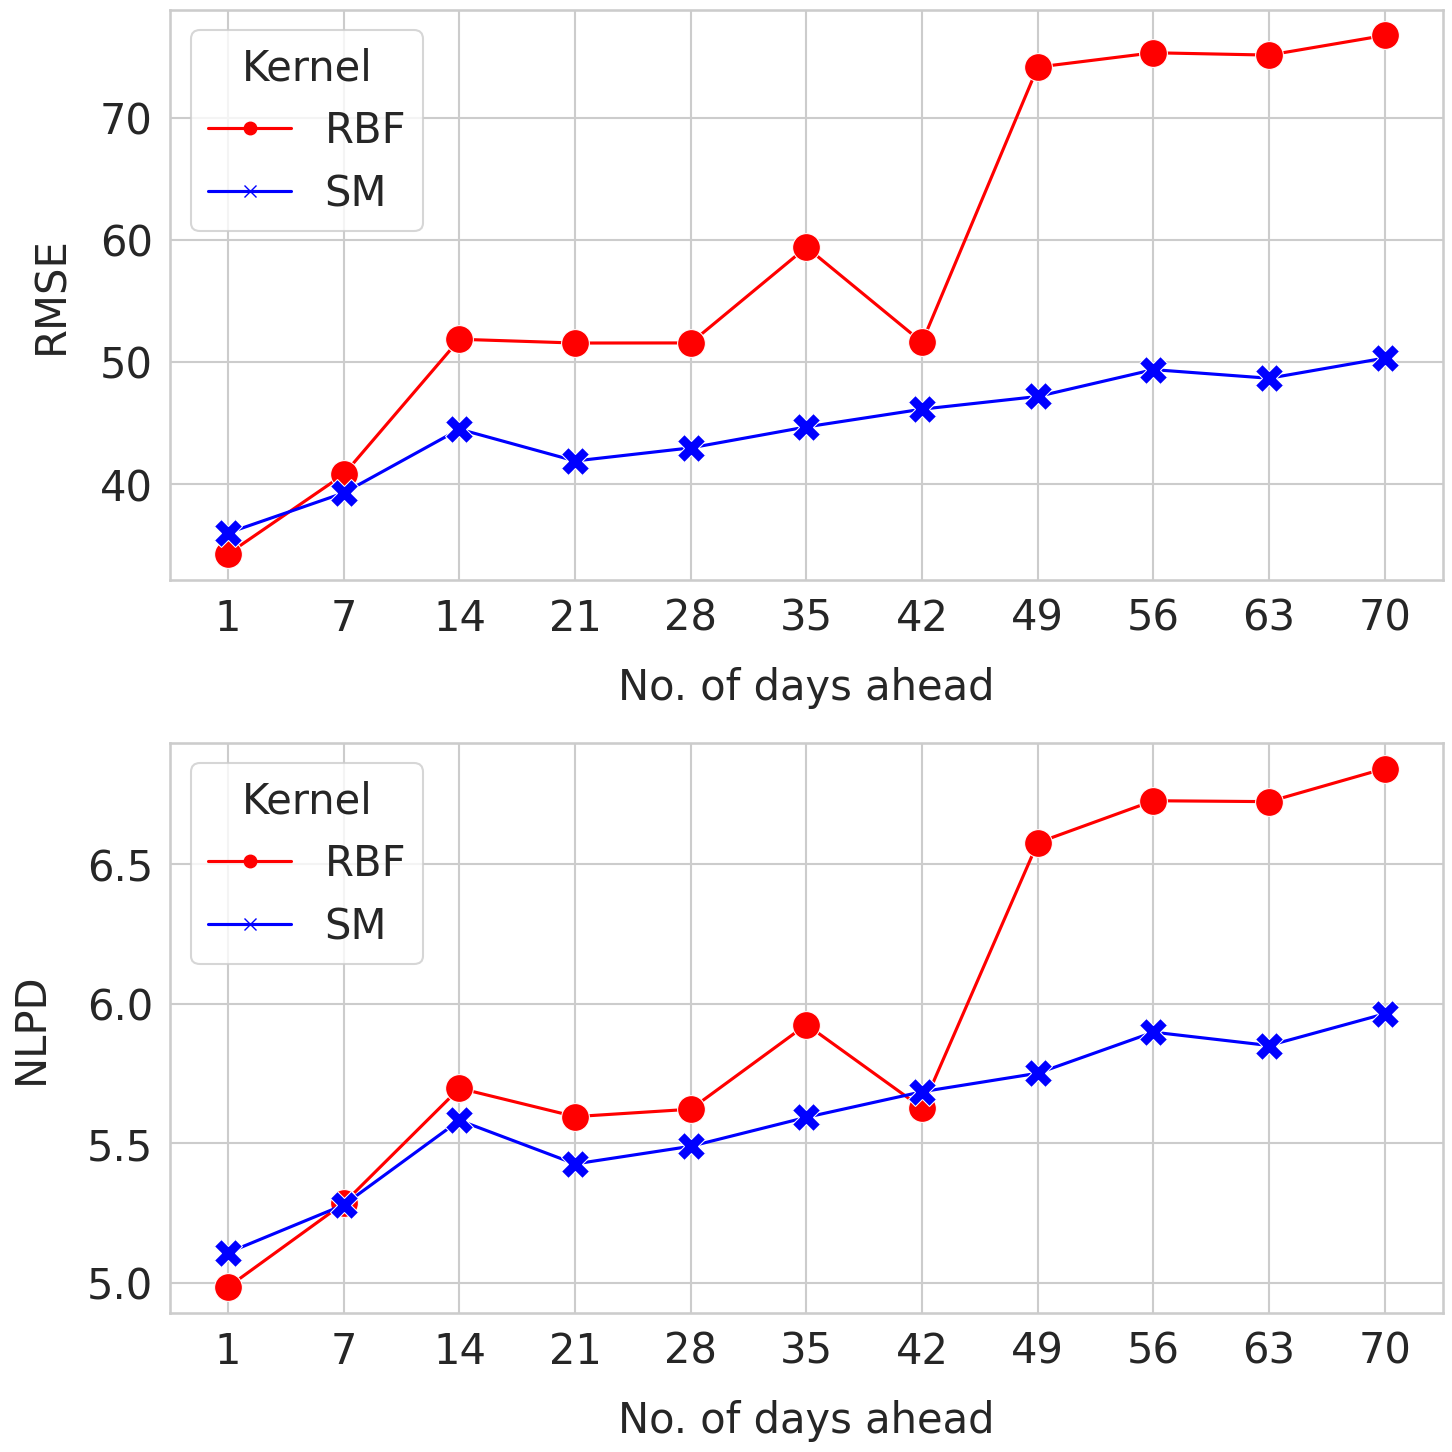

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Data setup
data = {
    "Time Step": ["1", "7", "14", "21", "28", "35", "42", "49", "56", "63", "70"],
    "RBF_RMSE": [34.27975191, 40.78841724, 51.86255012, 51.5528778, 51.56140241, 59.40592741, 51.61318664, 74.16669166, 75.33982591, 75.14879913, 76.76114997],
    "SM_RMSE": [35.99416926, 39.27244411, 44.49418441, 41.88831563, 42.96337381, 44.67916376, 46.13445588, 47.17310439, 49.37442324, 48.666365, 50.32118574],
    "RBF_NLPD": [4.984499698, 5.28483093, 5.696817617, 5.595330986, 5.621767333, 5.925333512, 5.626416696, 6.577364772, 6.727918123, 6.72467609, 6.843343577],
    "SM_NLPD": [5.107589151, 5.278766169, 5.581862458, 5.425609055, 5.488920072, 5.592803698, 5.684501804, 5.750797116, 5.898122274, 5.850185358, 5.963816013]
}

df = pd.DataFrame(data)
df['Time Step'] = pd.Categorical(df['Time Step'], categories=["1", "7", "14", "21", "28", "35", "42", "49", "56", "63", "70"], ordered=True)

# Creating subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 15))  # 1 row, 2 columns
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=1.25)

# Creating custom handles for the legend
handles = [Line2D([], [], color='red', marker='o', linestyle='-', label='RBF'),
           Line2D([], [], color='blue', marker='x', linestyle='-', label='SM')]

# Plotting RMSE with markers on the first subplot
sns.lineplot(x='Time Step', y='value', hue='variable', palette=["red", "blue"], style='variable', markers=True, dashes=False, data=pd.melt(df, id_vars='Time Step', value_vars=['RBF_RMSE', 'SM_RMSE']), ax=axs[0], markersize = 20)
axs[0].set_xlabel('No. of days ahead', fontsize=30, labelpad=20)
axs[0].set_ylabel('RMSE', fontsize=30, labelpad=20)
axs[0].legend(handles=handles, title='Kernel', title_fontsize=30, fontsize=30)
axs[0].tick_params(labelsize=30)

# Plotting NLPD with markers on the second subplot
sns.lineplot(x='Time Step', y='value', hue='variable', palette=["red", "blue"], style='variable', markers=True, dashes=False, data=pd.melt(df, id_vars='Time Step', value_vars=['RBF_NLPD', 'SM_NLPD']), ax=axs[1], markersize = 20)
axs[1].set_xlabel('No. of days ahead', fontsize=30, labelpad=20)
axs[1].set_ylabel('NLPD', fontsize=30, labelpad=25)
axs[1].legend(handles=handles, title='Kernel', title_fontsize=30, fontsize=30)
axs[1].tick_params(labelsize=30)

plt.tight_layout()
plt.show()

# **GSM comparison analysis**

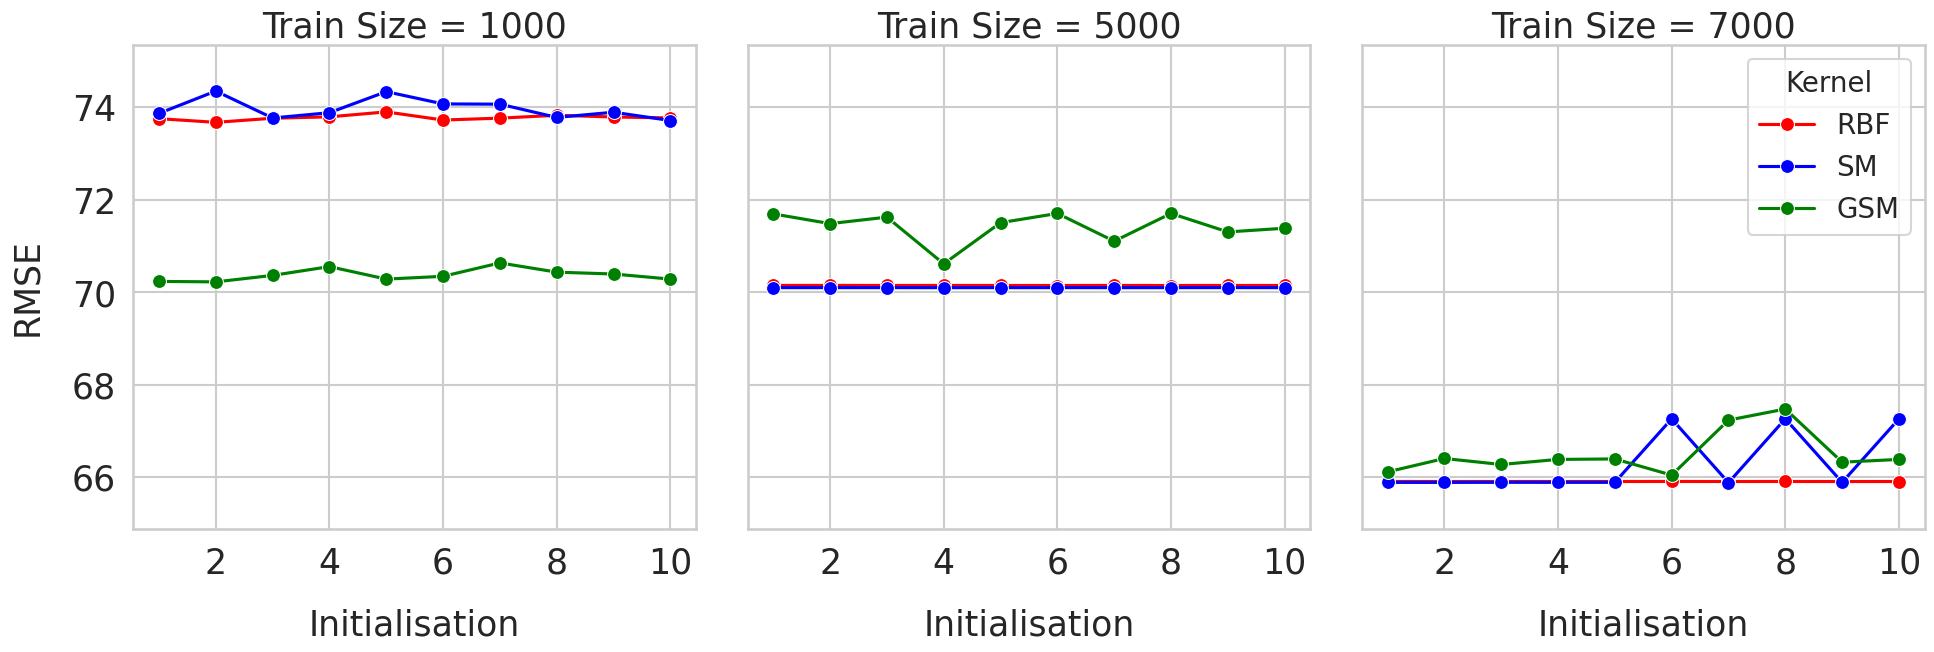

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Updated dataset with simplified kernel names
data = [
    # N = 1,000
    {'N': 1000, 'Init': 1, 'RBF': 73.74987632, 'SM': 73.86321842, 'GSM': 70.23},
    {'N': 1000, 'Init': 2, 'RBF': 73.67037614, 'SM': 74.34686202, 'GSM': 70.22},
    {'N': 1000, 'Init': 3, 'RBF': 73.75921162, 'SM': 73.76437111, 'GSM': 70.36},
    {'N': 1000, 'Init': 4, 'RBF': 73.78947289, 'SM': 73.87920199, 'GSM': 70.55},
    {'N': 1000, 'Init': 5, 'RBF': 73.89636382, 'SM': 74.33405588, 'GSM': 70.28},
    {'N': 1000, 'Init': 6, 'RBF': 73.72024171, 'SM': 74.068854, 'GSM': 70.34},
    {'N': 1000, 'Init': 7, 'RBF': 73.76131061, 'SM': 74.06346424, 'GSM': 70.63},
    {'N': 1000, 'Init': 8, 'RBF': 73.82307329, 'SM': 73.77722912, 'GSM': 70.43},
    {'N': 1000, 'Init': 9, 'RBF': 73.78647235, 'SM': 73.88910629, 'GSM': 70.39},
    {'N': 1000, 'Init': 10, 'RBF': 73.76566809, 'SM': 73.7101924, 'GSM': 70.28},
    # N = 5,000
    {'N': 5000, 'Init': 1, 'RBF': 70.14257505, 'SM': 70.09508732, 'GSM': 71.69},
    {'N': 5000, 'Init': 2, 'RBF': 70.14320052, 'SM': 70.0951203, 'GSM': 71.48},
    {'N': 5000, 'Init': 3, 'RBF': 70.14192617, 'SM': 70.09514658, 'GSM': 71.62},
    {'N': 5000, 'Init': 4, 'RBF': 70.14257901, 'SM': 70.09463678, 'GSM': 70.61},
    {'N': 5000, 'Init': 5, 'RBF': 70.14193569, 'SM': 70.09475119, 'GSM': 71.5},
    {'N': 5000, 'Init': 6, 'RBF': 70.14133667, 'SM': 70.09526589, 'GSM': 71.7},
    {'N': 5000, 'Init': 7, 'RBF': 70.14277706, 'SM': 70.09491687, 'GSM': 71.1},
    {'N': 5000, 'Init': 8, 'RBF': 70.14132954, 'SM': 70.09485892, 'GSM': 71.7},
    {'N': 5000, 'Init': 9, 'RBF': 70.14275337, 'SM': 70.09603656, 'GSM': 71.3},
    {'N': 5000, 'Init': 10, 'RBF': 70.14171896, 'SM': 70.094929, 'GSM': 71.38},
    # N = 7,000
    {'N': 7000, 'Init': 1, 'RBF': 65.90307185, 'SM': 65.88299078, 'GSM': 66.11},
    {'N': 7000, 'Init': 2, 'RBF': 65.90149172, 'SM': 65.88285675, 'GSM': 66.4},
    {'N': 7000, 'Init': 3, 'RBF': 65.90238169, 'SM': 65.88434237, 'GSM': 66.27},
    {'N': 7000, 'Init': 4, 'RBF': 65.90176381, 'SM': 65.88412649, 'GSM': 66.38},
    {'N': 7000, 'Init': 5, 'RBF': 65.90209657, 'SM': 65.88389507, 'GSM': 66.39},
    {'N': 7000, 'Init': 6, 'RBF': 65.90252006, 'SM': 67.25759319, 'GSM': 66.04},
    {'N': 7000, 'Init': 7, 'RBF': 65.90212975, 'SM': 65.87780588, 'GSM': 67.23},
    {'N': 7000, 'Init': 8, 'RBF': 65.90258287, 'SM': 67.25795705, 'GSM': 67.47},
    {'N': 7000, 'Init': 9, 'RBF': 65.90145872, 'SM': 65.88406139, 'GSM': 66.32},
    {'N': 7000, 'Init': 10, 'RBF': 65.9017671, 'SM': 67.25781971, 'GSM': 66.38},
]

# Convert the list to a DataFrame
df = pd.DataFrame(data)

# Reshape the DataFrame to 'long form' suitable for seaborn line plots
df_long = pd.melt(df, id_vars=['N', 'Init'], var_name='Kernel', value_name='RMSE')

# Setting the color palette for the kernels
kernel_colors = {"RBF": "red", "SM": "blue", "GSM": "green"}

# Creating the plots
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)

for ax, n_value in zip(axes, df['N'].unique()):
    sns.lineplot(
        data=df_long[df_long['N'] == n_value],
        x='Init',
        y='RMSE',
        hue='Kernel',
        palette=kernel_colors,
        marker='o',
        ax=ax, markersize=10
    )
    ax.set_title(f'Train Size = {n_value}', fontsize=25)
    ax.set_xlabel('Initialisation', fontsize=25, labelpad=20)
    ax.set_ylabel('RMSE', fontsize=25, labelpad=20)
    ax.set_ylim(df_long['RMSE'].min() - 1, df_long['RMSE'].max() + 1)  # Slightly wider ylim for better visuals
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.grid(True)

# Adjust the figure layout
plt.tight_layout()

# Remove the legends for all but the last plot
for ax in axes[:-1]:
    ax.get_legend().remove()

# Adjust legend on the last plot
axes[-1].legend(title='Kernel', fontsize=20, title_fontsize=20)

# Show the plot
plt.show()


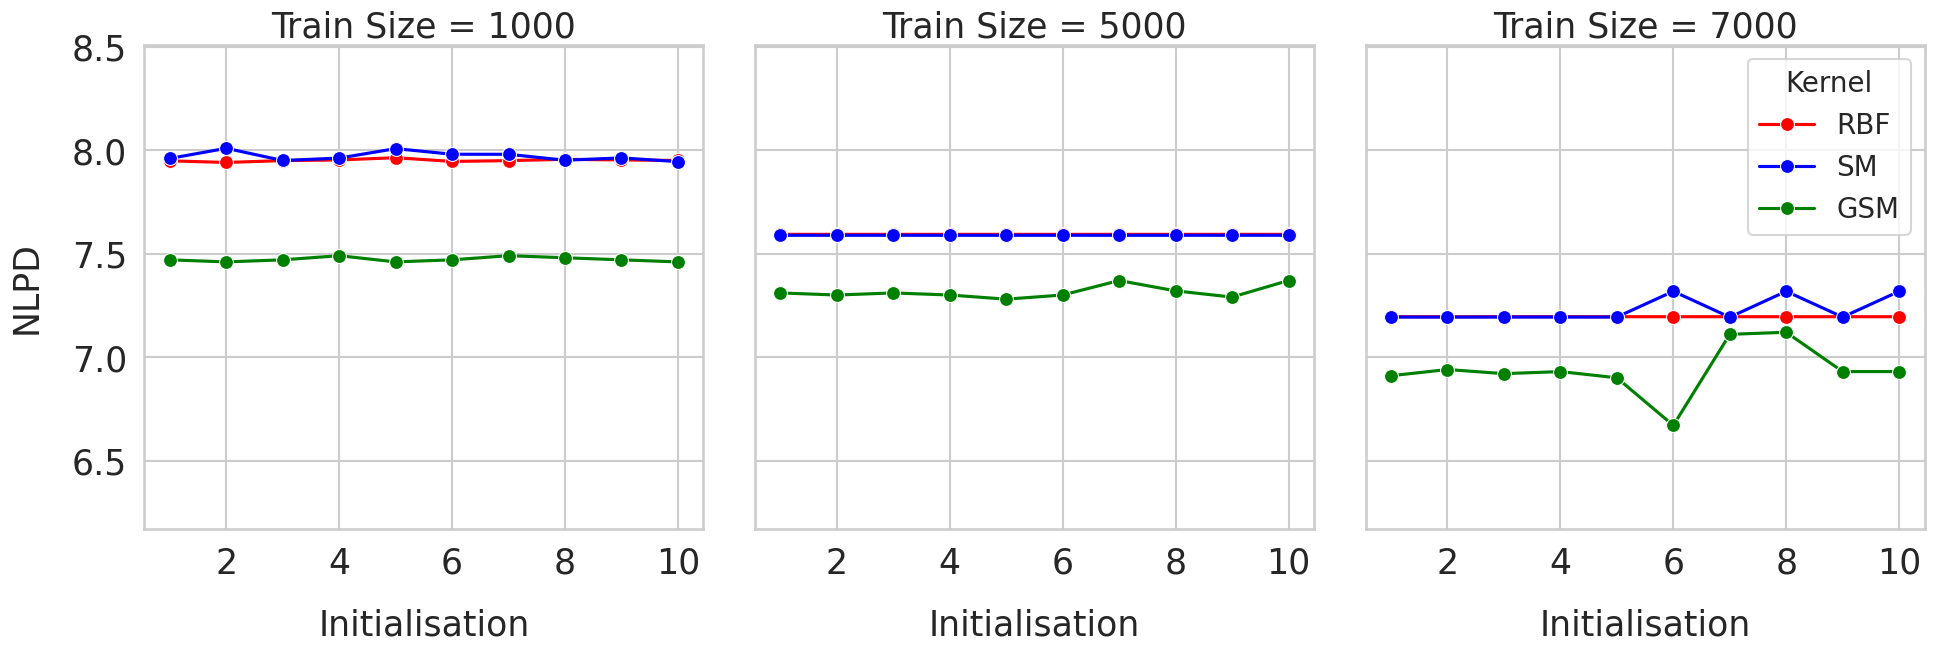

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Creating the updated data including all NLPD values with GSM column included
data = [
    {'N': 1000, 'Init': 1, 'RBF': 7.948403817, 'SM': 7.95996563, 'GSM': 7.47},
    {'N': 1000, 'Init': 2, 'RBF': 7.940500308, 'SM': 8.008937233, 'GSM': 7.46},
    {'N': 1000, 'Init': 3, 'RBF': 7.94952677, 'SM': 7.95007789, 'GSM': 7.47},
    {'N': 1000, 'Init': 4, 'RBF': 7.952753912, 'SM': 7.961722613, 'GSM': 7.49},
    {'N': 1000, 'Init': 5, 'RBF': 7.963401584, 'SM': 8.007357683, 'GSM': 7.46},
    {'N': 1000, 'Init': 6, 'RBF': 7.945522848, 'SM': 7.980255126, 'GSM': 7.47},
    {'N': 1000, 'Init': 7, 'RBF': 7.949418013, 'SM': 7.979972825, 'GSM': 7.49},
    {'N': 1000, 'Init': 8, 'RBF': 7.955715049, 'SM': 7.951360989, 'GSM': 7.48},
    {'N': 1000, 'Init': 9, 'RBF': 7.952732411, 'SM': 7.962665562, 'GSM': 7.47},
    {'N': 1000, 'Init': 10, 'RBF': 7.950165021, 'SM': 7.944560205, 'GSM': 7.46},
    {'N': 5000, 'Init': 1, 'RBF': 7.593116962, 'SM': 7.5885605, 'GSM': 7.31},
    {'N': 5000, 'Init': 2, 'RBF': 7.593177433, 'SM': 7.588563775, 'GSM': 7.3},
    {'N': 5000, 'Init': 3, 'RBF': 7.593054547, 'SM': 7.588566198, 'GSM': 7.31},
    {'N': 5000, 'Init': 4, 'RBF': 7.593117343, 'SM': 7.588516824, 'GSM': 7.3},
    {'N': 5000, 'Init': 5, 'RBF': 7.593055585, 'SM': 7.588528052, 'GSM': 7.28},
    {'N': 5000, 'Init': 6, 'RBF': 7.592997664, 'SM': 7.58857764, 'GSM': 7.3},
    {'N': 5000, 'Init': 7, 'RBF': 7.593136613, 'SM': 7.58854366, 'GSM': 7.37},
    {'N': 5000, 'Init': 8, 'RBF': 7.592996886, 'SM': 7.588538442, 'GSM': 7.32},
    {'N': 5000, 'Init': 9, 'RBF': 7.593134135, 'SM': 7.588650923, 'GSM': 7.29},
    {'N': 5000, 'Init': 10, 'RBF': 7.593034364, 'SM': 7.588545149, 'GSM': 7.37},
    {'N': 7000, 'Init': 1, 'RBF': 7.195213404, 'SM': 7.193405864, 'GSM': 6.91},
    {'N': 7000, 'Init': 2, 'RBF': 7.195070365, 'SM': 7.193393587, 'GSM': 6.94},
    {'N': 7000, 'Init': 3, 'RBF': 7.195150708, 'SM': 7.193528044, 'GSM': 6.92},
    {'N': 7000, 'Init': 4, 'RBF': 7.195095054, 'SM': 7.193508545, 'GSM': 6.93},
    {'N': 7000, 'Init': 5, 'RBF': 7.195124758, 'SM': 7.193487805, 'GSM': 6.9},
    {'N': 7000, 'Init': 6, 'RBF': 7.195163624, 'SM': 7.317878397, 'GSM': 6.67},
    {'N': 7000, 'Init': 7, 'RBF': 7.195127624, 'SM': 7.192942521, 'GSM': 7.11},
    {'N': 7000, 'Init': 8, 'RBF': 7.195168872, 'SM': 7.317911973, 'GSM': 7.12},
    {'N': 7000, 'Init': 9, 'RBF': 7.195067157, 'SM': 7.193502702, 'GSM': 6.93},
    {'N': 7000, 'Init': 10, 'RBF': 7.195095024, 'SM': 7.317899308, 'GSM': 6.93},
]

# Convert the list to a DataFrame
df = pd.DataFrame(data)

# Reshape the DataFrame to 'long form' which is suitable for seaborn line plots
df_long = pd.melt(df, id_vars=['N', 'Init'], var_name='Kernel', value_name='NLPD')

# Setting the color palette for the kernels, including GSM
kernel_colors = {"RBF": "red", "SM": "blue", "GSM": "green"}

# Creating the plots with NLPD values
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)

for ax, n_value in zip(axes, df['N'].unique()):
    sns.lineplot(
        data=df_long[df_long['N'] == n_value],
        x='Init',
        y='NLPD',
        hue='Kernel',
        palette=kernel_colors,
        marker='o',
        ax=ax,markersize=10
    )
    ax.set_title(f'Train Size = {n_value}', fontsize=25)
    ax.set_xlabel('Initialisation', fontsize=25, labelpad=20)
    ax.set_ylabel('NLPD', fontsize=25, labelpad=20)
    ax.set_ylim(df_long['NLPD'].min() - 0.5, df_long['NLPD'].max() + 0.5)  # Adjust y-axis limits for better visualization
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.grid(True)

plt.tight_layout()

# Remove the legends for all but the last plot
for ax in axes[:-1]:
    ax.get_legend().remove()

# Adjust legend on the last plot
axes[-1].legend(title='Kernel', fontsize=20, title_fontsize=20)

plt.show()

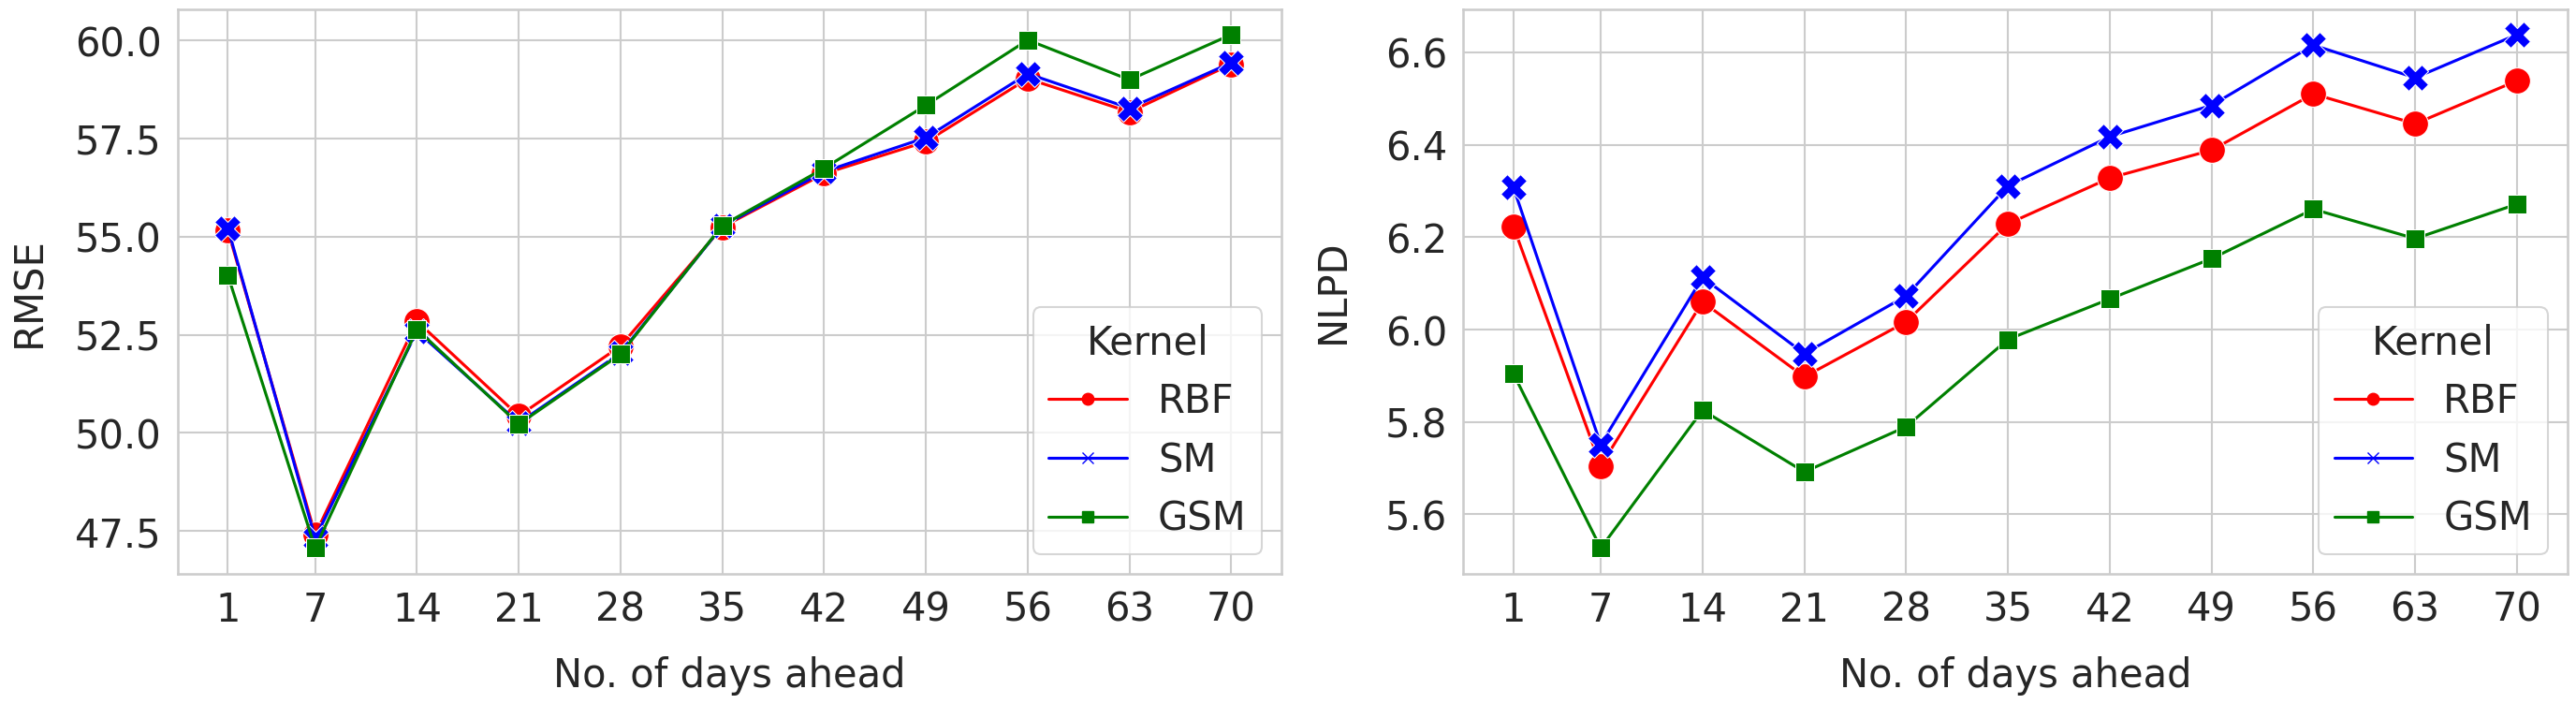

In [ ]:
# Updated Data with new values
data_updated = {
    "Time Step": [1, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70],
    "RBF_RMSE": [55.15821713, 47.4103743, 52.84713449, 50.4352019, 52.21459975, 55.24577266, 56.60666506, 57.41794027, 59.02433338, 58.17609812, 59.39429822],
    "SM_RMSE": [55.2211747, 47.32062992, 52.59257503, 50.25507552, 52.03575552, 55.27051946, 56.65853192, 57.52314, 59.15113942, 58.27429538, 59.43165213],
    "GSM_RMSE": [54.01358113, 47.06853877, 52.64360575, 50.22365368, 52.00597857, 55.28786825, 56.7426552, 58.34870898, 60.00982946, 58.99539573, 60.14799666],
    "RBF_NLPD": [6.222605059, 5.704869511, 6.059974898, 5.897686145, 6.016681005, 6.228887143, 6.328051196, 6.388308909, 6.510167817, 6.445403207, 6.538710334],
    "SM_NLPD": [6.307266575, 5.751263413, 6.112764501, 5.947773096, 6.07278102, 6.311003806, 6.417625947, 6.485379419, 6.615738961, 6.545074757, 6.638568031],
    "GSM_NLPD": [5.904016074, 5.52692348, 5.825454627, 5.691776996, 5.789616753, 5.97871278, 6.066214302, 6.153465745, 6.260531969, 6.196873105, 6.271547974]
}

df_updated = pd.DataFrame(data_updated)
df_updated['Time Step'] = pd.Categorical(df_updated['Time Step'], categories=[1, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70], ordered=True)

# Updating custom handles for the legend to include GSM
handles_updated = [
    Line2D([], [], color='red', marker='o', linestyle='-', label='RBF'),
    Line2D([], [], color='blue', marker='x', linestyle='-', label='SM'),
    Line2D([], [], color='green', marker='s', linestyle='-', label='GSM')  # Adding GSM to legend
]

# Adjusting the plots to ensure the x-axis starts from 1

# Re-plotting with the x-axis starting from 1
fig, axs = plt.subplots(1, 2, figsize=(28, 8))

# Plotting RMSE with markers on the first subplot
sns.lineplot(x='Time Step', y='value', hue='variable', palette=["red", "blue", "green"], style='variable', markers=True, dashes=False, data=pd.melt(df_updated, id_vars='Time Step', value_vars=['RBF_RMSE', 'SM_RMSE', 'GSM_RMSE']), ax=axs[0], markersize=20)
axs[0].set_xlabel('No. of days ahead', fontsize=30, labelpad=20)
axs[0].set_ylabel('RMSE', fontsize=30, labelpad=20)
axs[0].legend(handles=handles_updated, title='Kernel', title_fontsize=30, fontsize=30)
axs[0].tick_params(labelsize=30)
axs[0].set_xticks(df_updated['Time Step'])  # Setting x-ticks to ensure starting from 1

# Plotting NLPD with markers on the second subplot
sns.lineplot(x='Time Step', y='value', hue='variable', palette=["red", "blue", "green"], style='variable', markers=True, dashes=False, data=pd.melt(df_updated, id_vars='Time Step', value_vars=['RBF_NLPD', 'SM_NLPD', 'GSM_NLPD']), ax=axs[1], markersize=20)
axs[1].set_xlabel('No. of days ahead', fontsize=30, labelpad=20)
axs[1].set_ylabel('NLPD', fontsize=30, labelpad=25)
axs[1].legend(handles=handles_updated, title='Kernel', title_fontsize=30, fontsize=30)
axs[1].tick_params(labelsize=30)
axs[1].set_xticks(df_updated['Time Step'])  # Setting x-ticks to ensure starting from 1

plt.tight_layout()
plt.show()

# **Multi-Task Gaussian Processes**

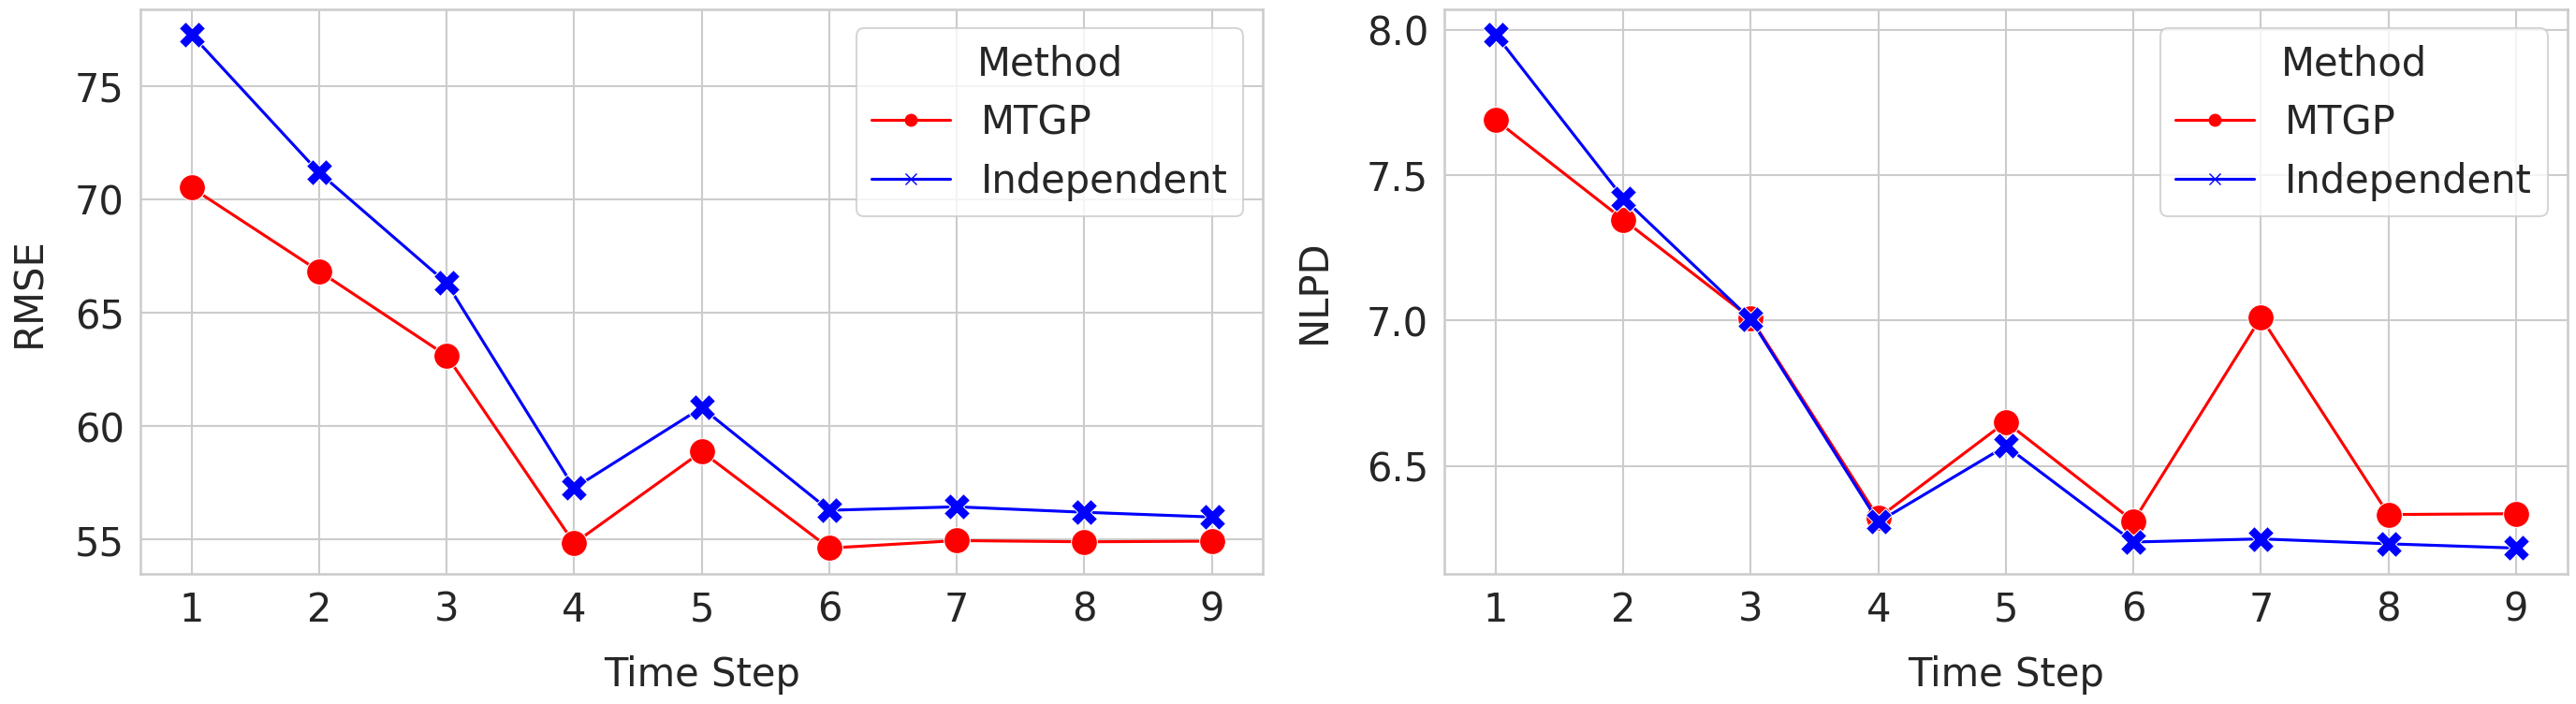

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Updated Data setup
data = {
    "Time Step": ["1", "2", "3", "4", "5", "6", "7", "8", "9"],
    "MTGP_RMSE": [70.5108372, 66.83250469, 63.10528992, 54.83833368, 58.88222784, 54.62880247, 54.95903978, 54.90569483, 54.93319789],
    "Independent_RMSE": [77.25972985, 71.1756223, 66.31077316, 57.27378695, 60.81801842, 56.29556046, 56.44709078, 56.20658806, 55.99726392],
    "MTGP_NLPD": [7.688753331, 7.346340207, 7.007204593, 6.320685597, 6.650824485, 6.30926999, 7.010046037, 6.332345863, 6.335196582],
    "Independent_NLPD": [7.982552722, 7.419866674, 7.003071716, 6.307040445, 6.567991077, 6.237887188, 6.248560653, 6.231684289, 6.217057575]
}

df = pd.DataFrame(data)
# Ensure time steps are ordered correctly
df['Time Step'] = pd.Categorical(df['Time Step'], categories=["1", "2", "3", "4", "5", "6", "7", "8", "9"], ordered=True)

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(28, 8))  # 1 row, 2 columns
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=1.25)

# Adjusting custom handles for the legend to reflect new categories
handles = [
    Line2D([], [], color='red', marker='o', linestyle='-', label='MTGP'),
    Line2D([], [], color='blue', marker='x', linestyle='-', label='Independent')
]

# Plotting RMSE with markers on the first subplot
sns.lineplot(x='Time Step', y='value', hue='variable', palette=["red", "blue"], style='variable', markers=True, dashes=False, data=pd.melt(df, id_vars='Time Step', value_vars=['MTGP_RMSE', 'Independent_RMSE']), ax=axs[0], markersize=20)
axs[0].set_xlabel('Time Step', fontsize=30, labelpad=20)
axs[0].set_ylabel('RMSE', fontsize=30, labelpad=20)
axs[0].legend(handles=handles, title='Method', title_fontsize=30, fontsize=30)
axs[0].tick_params(labelsize=30)

# Plotting NLPD with markers on the second subplot
sns.lineplot(x='Time Step', y='value', hue='variable', palette=["red", "blue"], style='variable', markers=True, dashes=False, data=pd.melt(df, id_vars='Time Step', value_vars=['MTGP_NLPD', 'Independent_NLPD']), ax=axs[1],markersize=20)
axs[1].set_xlabel('Time Step', fontsize=30, labelpad=20)
axs[1].set_ylabel('NLPD', fontsize=30, labelpad=25)
axs[1].legend(handles=handles, title='Method', title_fontsize=30, fontsize=30)
axs[1].tick_params(labelsize=30)

plt.tight_layout()
plt.show()


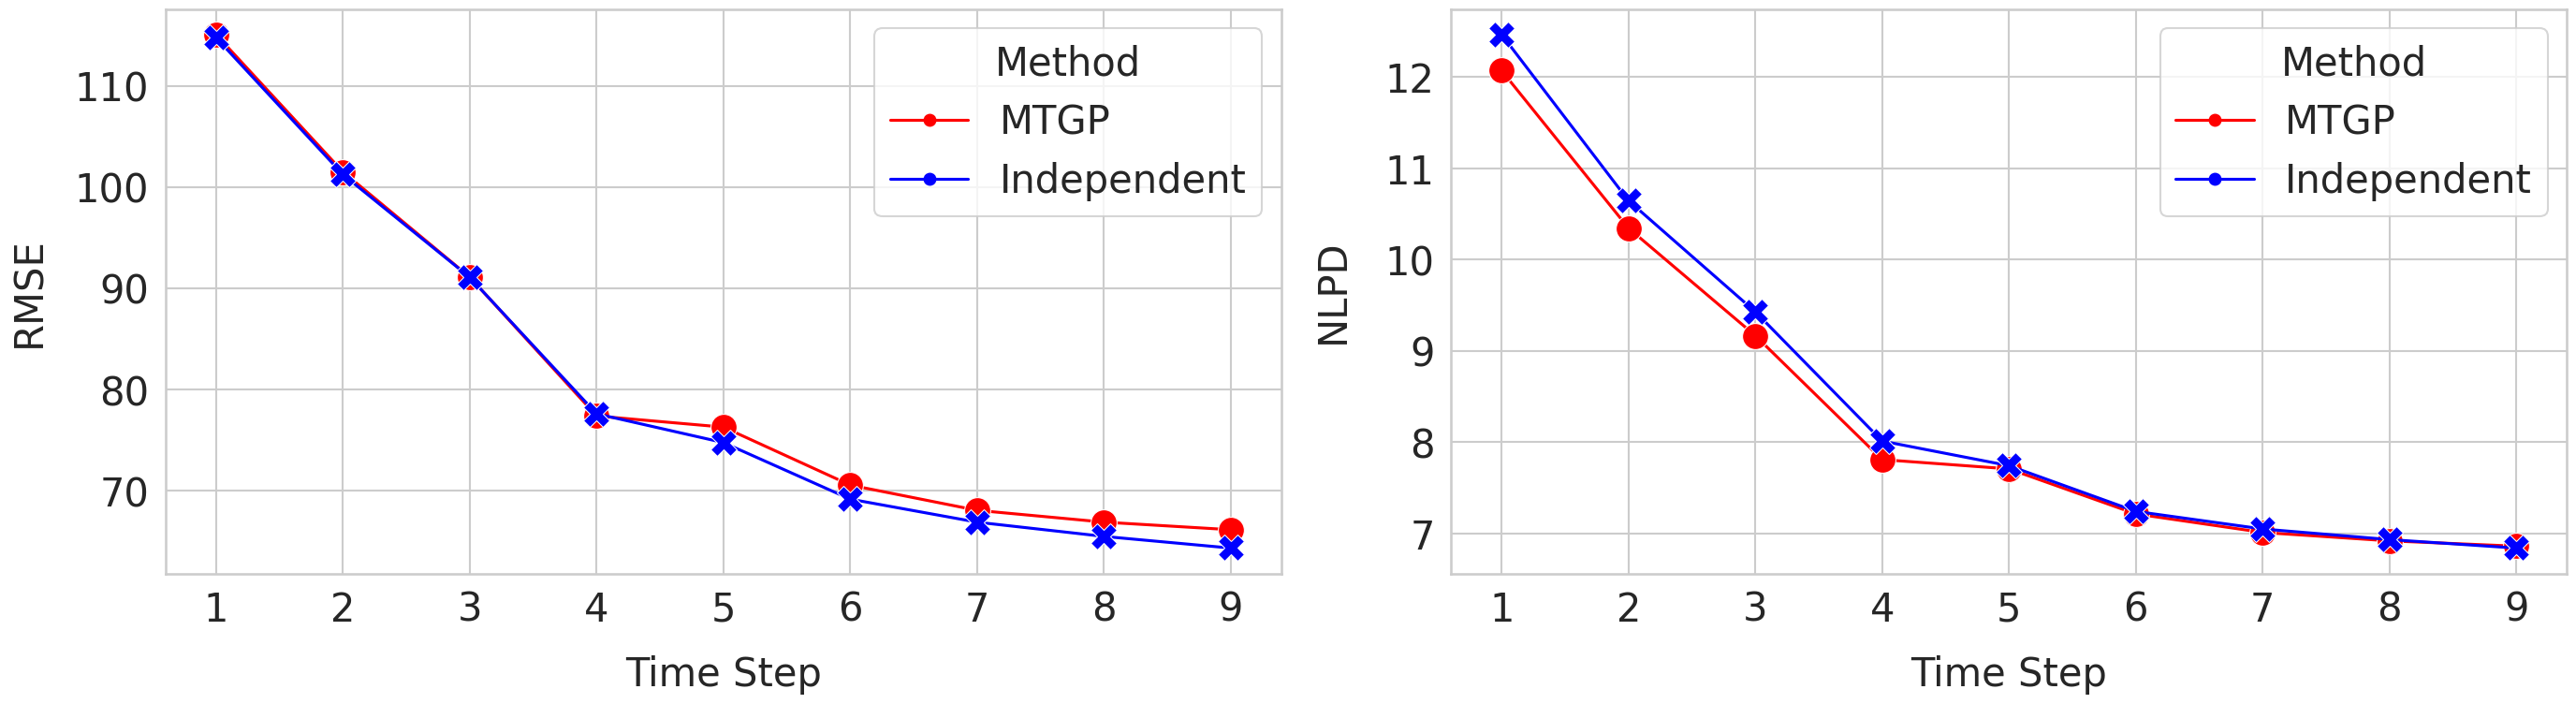

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Updated Data setup with new dataset
data = {
    "Time Step": ["1", "2", "3", "4", "5", "6", "7", "8", "9"],
    "MTGP_RMSE": [115.0910607, 101.5183003, 91.10734934, 77.37660514, 76.27669273, 70.54133791, 68.04699921, 66.88047275, 66.13119657],
    "Independent_RMSE": [114.7872007, 101.2542569, 91.08648714, 77.58937602, 74.74572324, 69.15255857, 66.87544438, 65.46727983, 64.31569609],
    "MTGP_NLPD": [12.0720728, 10.34619209, 9.167425106, 7.808416775, 7.7068316, 7.212852065, 7.010046037, 6.917698304, 6.859469965],
    "Independent_NLPD": [12.46736726, 10.64700864, 9.429261347, 8.011675095, 7.74170938, 7.240609904, 7.047792874, 6.931759869, 6.838679218]
}

df = pd.DataFrame(data)
df['Time Step'] = pd.Categorical(df['Time Step'], categories=["1", "2", "3", "4", "5", "6", "7", "8", "9"], ordered=True)

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(28, 8))  # 1 row, 2 columns
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=1.25)

# Adjusting custom handles for the legend to reflect the updated categories
handles = [
    Line2D([], [], color='red', marker='o', linestyle='-', label='MTGP'),
    Line2D([], [], color='blue', marker='o', linestyle='-', label='Independent')
]

# Plotting RMSE with markers on the first subplot
sns.lineplot(x='Time Step', y='value', hue='variable', palette=["red", "blue"], style='variable', markers=True, dashes=False, data=pd.melt(df, id_vars='Time Step', value_vars=['MTGP_RMSE', 'Independent_RMSE']), ax=axs[0], markersize=20)
axs[0].set_xlabel('Time Step', fontsize=30, labelpad=20)
axs[0].set_ylabel('RMSE', fontsize=30, labelpad=20)
axs[0].legend(handles=handles, title='Method', title_fontsize=30, fontsize=30)
axs[0].tick_params(labelsize=30)

# Plotting NLPD with markers on the second subplot
sns.lineplot(x='Time Step', y='value', hue='variable', palette=["red", "blue"], style='variable', markers=True, dashes=False, data=pd.melt(df, id_vars='Time Step', value_vars=['MTGP_NLPD', 'Independent_NLPD']), ax=axs[1], markersize=20)
axs[1].set_xlabel('Time Step', fontsize=30, labelpad=20)
axs[1].set_ylabel('NLPD', fontsize=30, labelpad=25)
axs[1].legend(handles=handles, title='Method', title_fontsize=30, fontsize=30)
axs[1].tick_params(labelsize=30)

plt.tight_layout()
plt.show()


# **FITC and VFE GP**

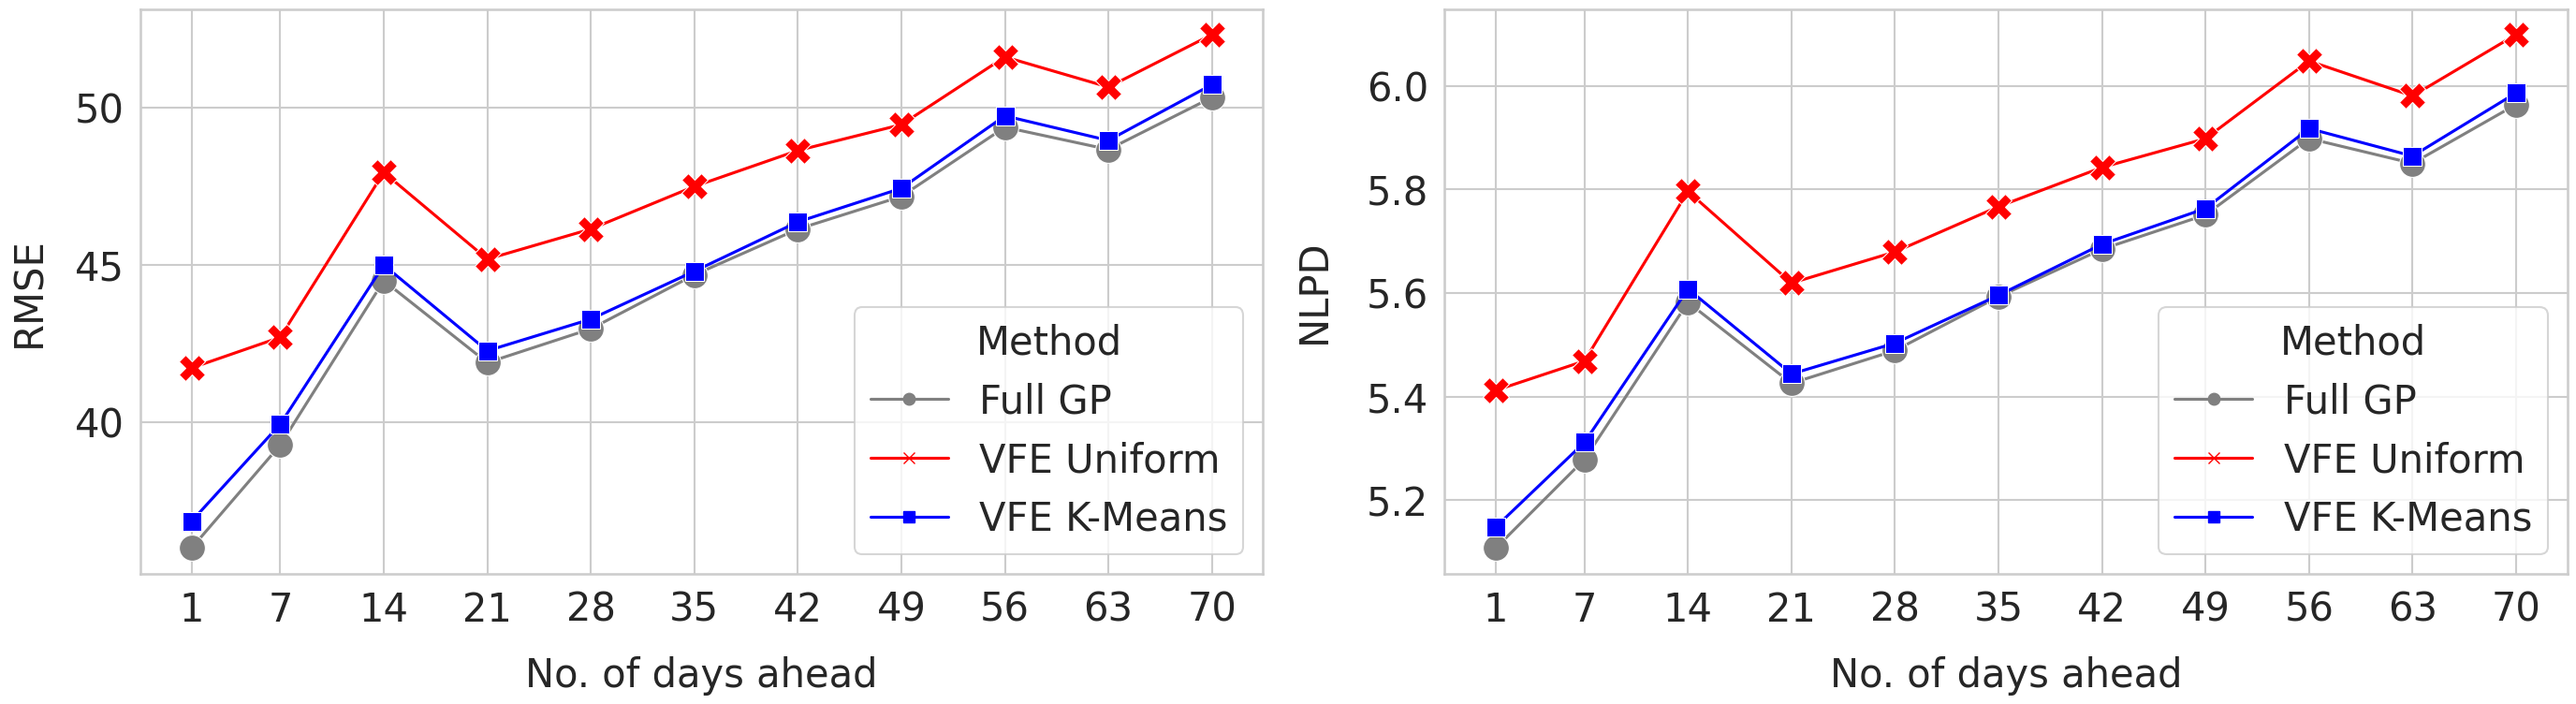

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Updated Data with new values for Full GP, VFE Uniform, and VFE K-Means
data_updated = {
    "Time Step": [1, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70],
    "Full_GP_RMSE": [35.99416926, 39.27244411, 44.49418441, 41.88831563, 42.96337381, 44.67916376, 46.13445588, 47.17310439, 49.37442324, 48.666365, 50.32118574],
    "VFE_Uniform_RMSE": [41.72014961, 42.69612004, 47.93652284, 45.18002456, 46.13678513, 47.49159193, 48.63350157, 49.45650987, 51.60824261, 50.64941012, 52.31903413],
    "VFE_K_Means_RMSE": [36.84689133, 39.93515953, 44.99133178, 42.26639925, 43.27259481, 44.7943662, 46.36293548, 47.43241188, 49.73474975, 48.95320673, 50.72786842],
    "Full_GP_NLPD": [5.107589151, 5.278766169, 5.581862458, 5.425609055, 5.488920072, 5.592803698, 5.684501804, 5.750797116, 5.898122274, 5.850185358, 5.963816013],
    "VFE_Uniform_NLPD": [5.411963552, 5.468752952, 5.796064129, 5.619153805, 5.679371734, 5.766768455, 5.842395108, 5.898003306, 6.047881561, 5.980311049, 6.098794469],
    "VFE_K_Means_NLPD": [5.148228025, 5.311729328, 5.607752419, 5.443807636, 5.503152403, 5.59552261, 5.694082058, 5.763191912, 5.917435063, 5.864265348, 5.986227037]
}

df_updated = pd.DataFrame(data_updated)
df_updated['Time Step'] = pd.Categorical(df_updated['Time Step'], categories=[1, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70], ordered=True)

# Updating custom handles for the legend to include Full GP, VFE Uniform, and VFE K-Means
handles_updated = [
    Line2D([], [], color='grey', marker='o', linestyle='-', label='Full GP'),
    Line2D([], [], color='red', marker='x', linestyle='-', label='VFE Uniform'),
    Line2D([], [], color='blue', marker='s', linestyle='-', label='VFE K-Means')  # Adding VFE K-Means to legend
]

# Re-plotting with the x-axis starting from 1
fig, axs = plt.subplots(1, 2, figsize=(28, 8))

# Plotting RMSE with markers on the first subplot
sns.lineplot(x='Time Step', y='value', hue='variable', palette=["grey", "red", "blue"], style='variable', markers=True, dashes=False, data=pd.melt(df_updated, id_vars='Time Step', value_vars=['Full_GP_RMSE', 'VFE_Uniform_RMSE', 'VFE_K_Means_RMSE']), ax=axs[0], markersize=20)
axs[0].set_xlabel('No. of days ahead', fontsize=30, labelpad=20)
axs[0].set_ylabel('RMSE', fontsize=30, labelpad=20)
axs[0].legend(handles=handles_updated, title='Method', title_fontsize=30, fontsize=30)
axs[0].tick_params(labelsize=30)
axs[0].set_xticks(df_updated['Time Step'])  # Ensuring x-ticks start from 1

# Plotting NLPD with markers on the second subplot
sns.lineplot(x='Time Step', y='value', hue='variable', palette=["grey", "red", "blue"], style='variable', markers=True, dashes=False, data=pd.melt(df_updated, id_vars='Time Step', value_vars=['Full_GP_NLPD', 'VFE_Uniform_NLPD', 'VFE_K_Means_NLPD']), ax=axs[1], markersize=20)
axs[1].set_xlabel('No. of days ahead', fontsize=30, labelpad=20)
axs[1].set_ylabel('NLPD', fontsize=30, labelpad=25)
axs[1].legend(handles=handles_updated, title='Method', title_fontsize=30, fontsize=30)
axs[1].tick_params(labelsize=30)
axs[1].set_xticks(df_updated['Time Step'])  # Ensuring x-ticks start from 1

plt.tight_layout()
plt.show()

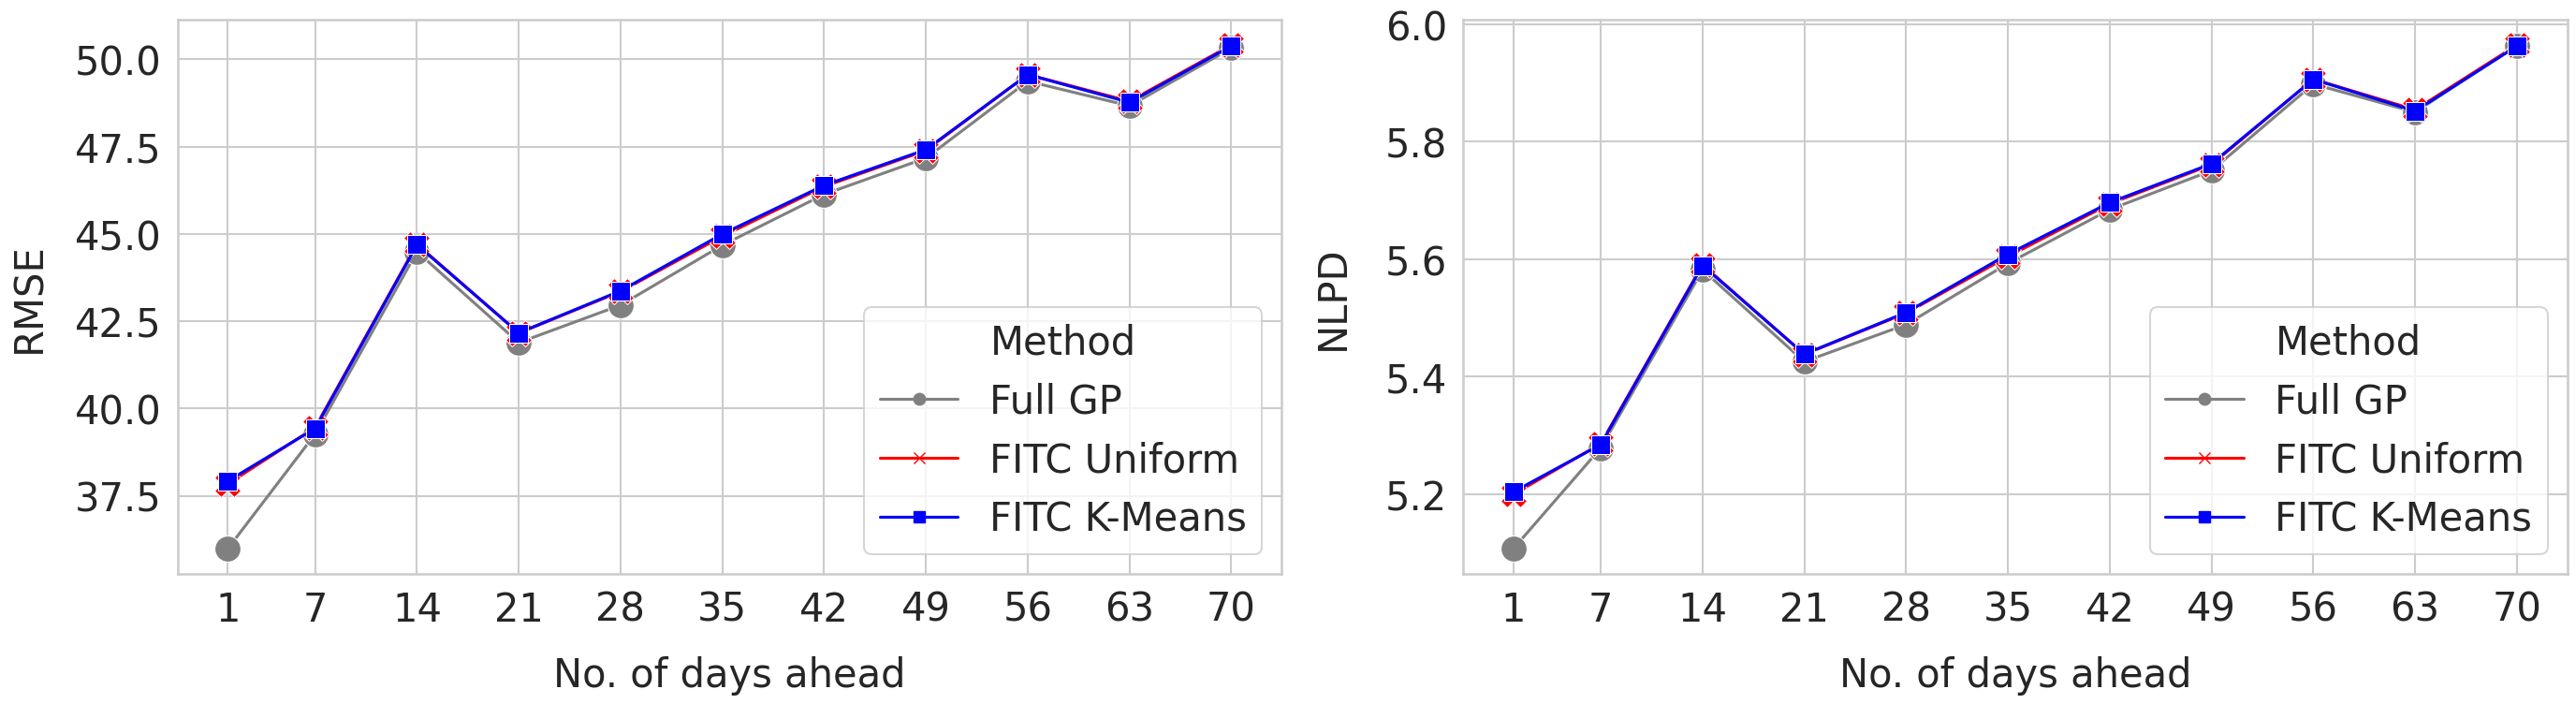

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Updated Data with new values for Full GP, FITC Uniform, and FITC K-Means
data_updated = {
    "Time Step": [1, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70],
    "Full_GP_RMSE": [35.99416926, 39.27244411, 44.49418441, 41.88831563, 42.96337381, 44.67916376, 46.13445588, 47.17310439, 49.37442324, 48.666365, 50.32118574],
    "FITC_Uniform_RMSE": [37.84758665, 39.46148118, 44.70845726, 42.16100175, 43.35422354, 44.93504922, 46.35894448, 47.39267484, 49.5661852, 48.79889574, 50.41006879],
    "FITC_K_Means_RMSE": [37.92772416, 39.43536784, 44.69013985, 42.16931909, 43.37201724, 44.99858126, 46.39320021, 47.4155605, 49.56237496, 48.76707774, 50.3845121],
    "Full_GP_NLPD": [5.107589151, 5.278766169, 5.581862458, 5.425609055, 5.488920072, 5.592803698, 5.684501804, 5.750797116, 5.898122274, 5.850185358, 5.963816013],
    "FITC_Uniform_NLPD": [5.199938364, 5.286012165, 5.590577759, 5.437931958, 5.50831437, 5.604543079, 5.694177506, 5.760997215, 5.906347929, 5.854296811, 5.964536785],
    "FITC_K_Means_NLPD": [5.204130409, 5.28459551, 5.589457012, 5.43842311, 5.509386429, 5.60849373, 5.696378674, 5.762497189, 5.906093428, 5.852161937, 5.962767755]
}

df_updated = pd.DataFrame(data_updated)
df_updated['Time Step'] = pd.Categorical(df_updated['Time Step'], categories=[1, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70], ordered=True)

# Updating custom handles for the legend to include Full GP, FITC Uniform, and FITC K-Means
handles_updated = [
    Line2D([], [], color='grey', marker='o', linestyle='-', label='Full GP'),
    Line2D([], [], color='red', marker='x', linestyle='-', label='FITC Uniform'),
    Line2D([], [], color='blue', marker='s', linestyle='-', label='FITC K-Means')  # Adding FITC K-Means to legend
]

# Re-plotting with the x-axis starting from 1
fig, axs = plt.subplots(1, 2, figsize=(28, 8))

# Plotting RMSE with markers on the first subplot
sns.lineplot(x='Time Step', y='value', hue='variable', palette=["grey", "red", "blue"], style='variable', markers=True, dashes=False, data=pd.melt(df_updated, id_vars='Time Step', value_vars=['Full_GP_RMSE', 'FITC_Uniform_RMSE', 'FITC_K_Means_RMSE']), ax=axs[0], markersize=20)
axs[0].set_xlabel('No. of days ahead', fontsize=30, labelpad=20)
axs[0].set_ylabel('RMSE', fontsize=30, labelpad=20)
axs[0].legend(handles=handles_updated, title='Method', title_fontsize=30, fontsize=30)
axs[0].tick_params(labelsize=30)
axs[0].set_xticks(df_updated['Time Step'])  # Ensuring x-ticks start from 1

# Plotting NLPD with markers on the second subplot
sns.lineplot(x='Time Step', y='value', hue='variable', palette=["grey", "red", "blue"], style='variable', markers=True, dashes=False, data=pd.melt(df_updated, id_vars='Time Step', value_vars=['Full_GP_NLPD', 'FITC_Uniform_NLPD', 'FITC_K_Means_NLPD']), ax=axs[1], markersize=20)
axs[1].set_xlabel('No. of days ahead', fontsize=30, labelpad=20)
axs[1].set_ylabel('NLPD', fontsize=30, labelpad=25)
axs[1].legend(handles=handles_updated, title='Method', title_fontsize=30, fontsize=30)
axs[1].tick_params(labelsize=30)
axs[1].set_xticks(df_updated['Time Step'])  # Ensuring x-ticks start from 1

plt.tight_layout()
plt.show()